🚀 KOORDİNATLI VERİ ANALİZİ BAŞLIYOR...
📖 Okunuyor: hasila.xls (Başlangıç Satırı: 6)
📖 Okunuyor: issizlik.xls (Başlangıç Satırı: 8)
📖 Okunuyor: sinema.xls (Başlangıç Satırı: 6)
📖 Okunuyor: tiyatro.xls (Başlangıç Satırı: 7)
✅ Analiz için 81 il hazırlandı.


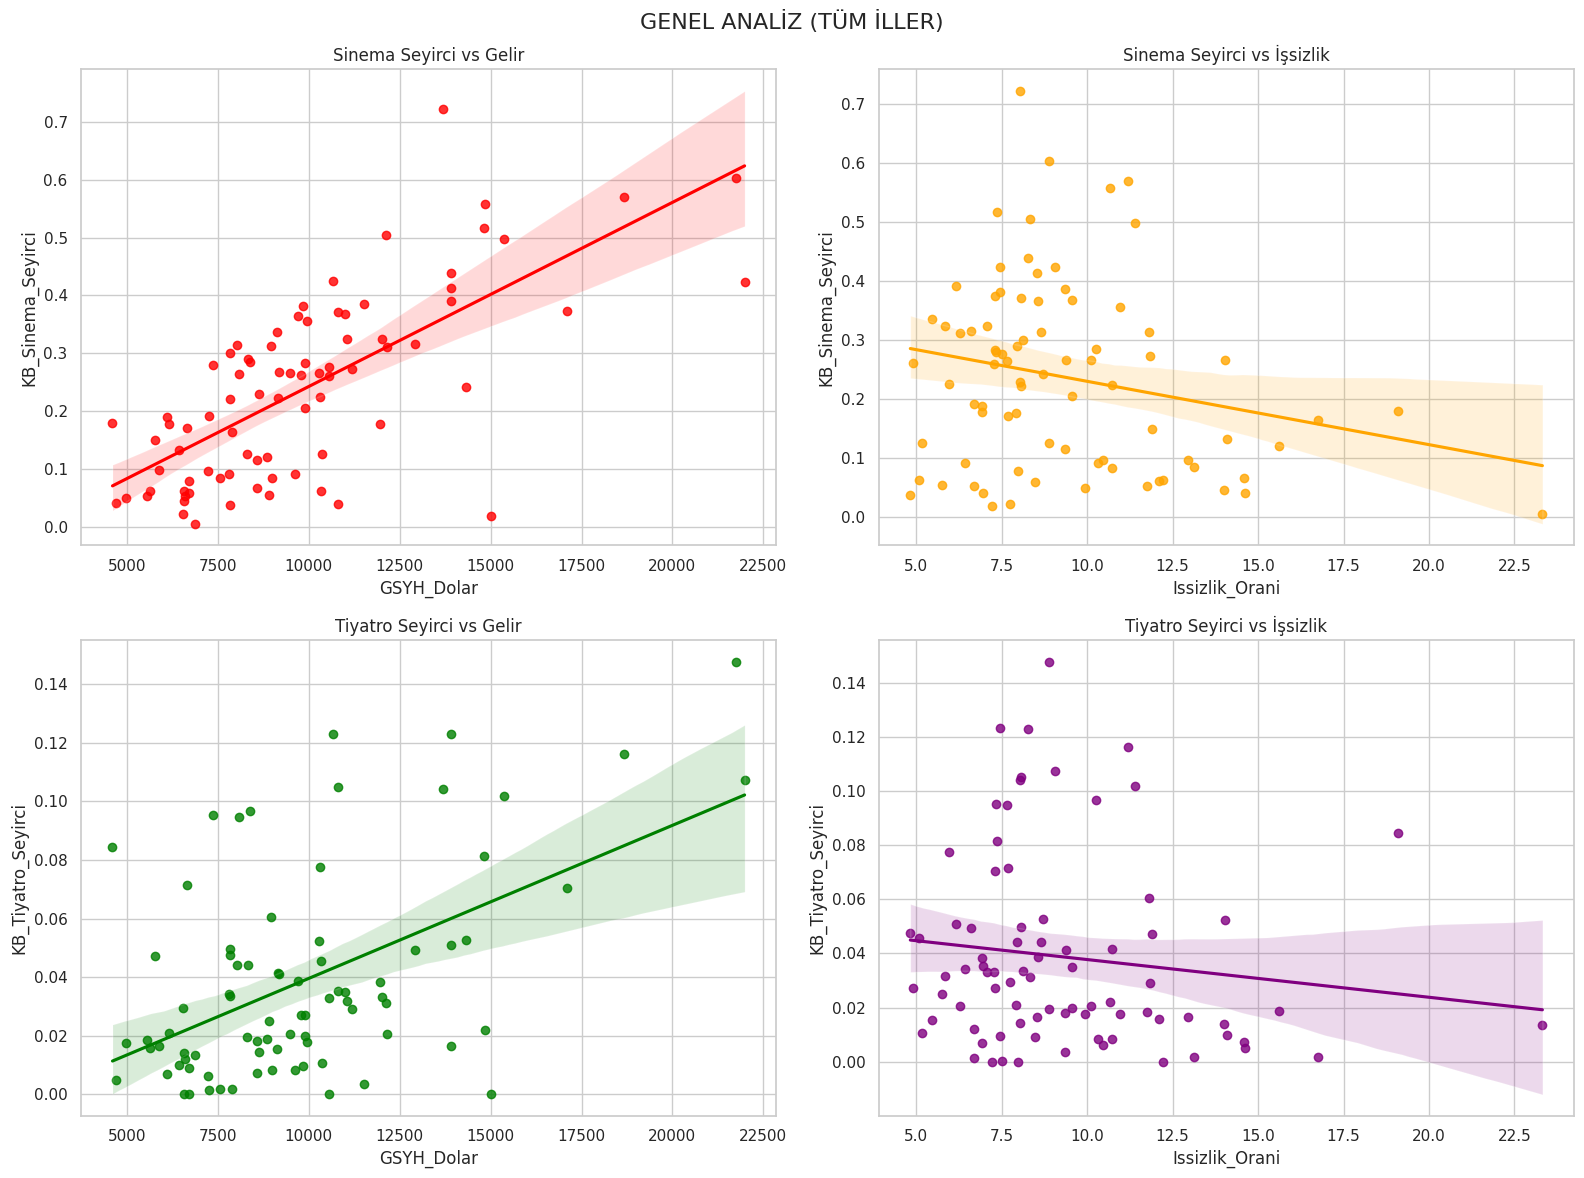

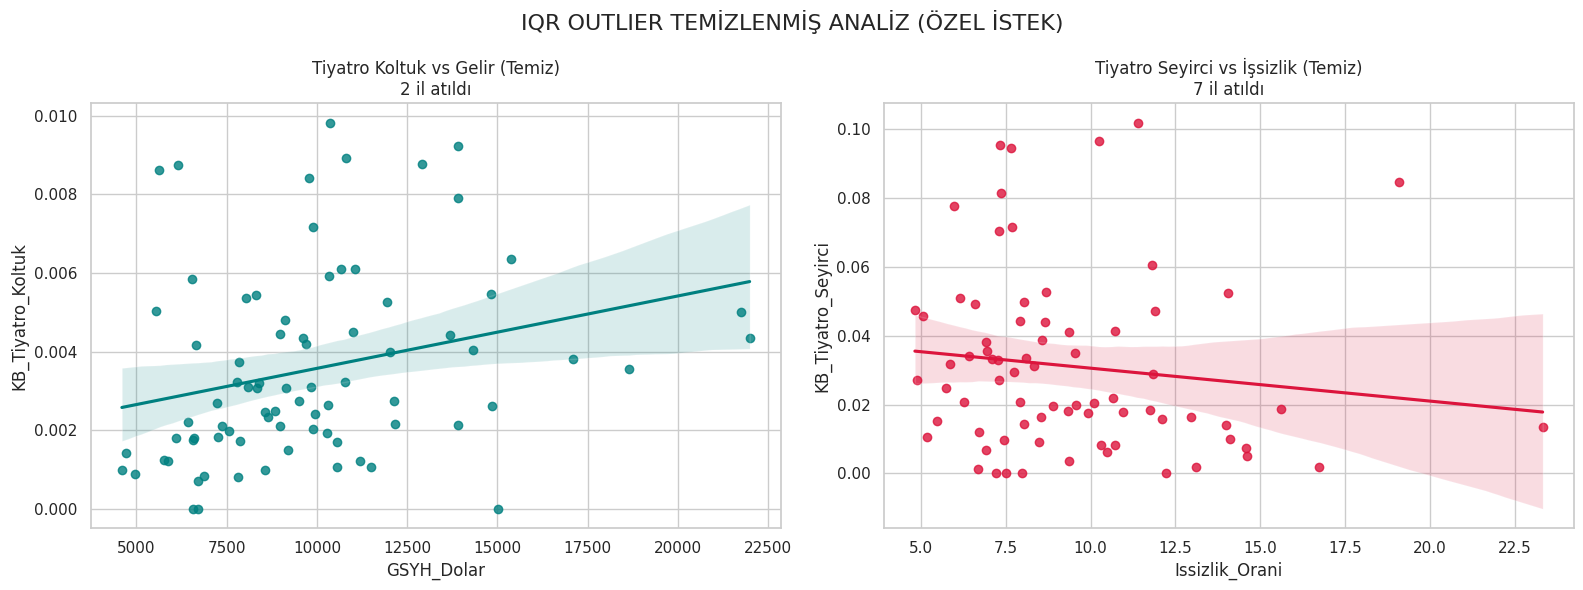


📋 TABLO 1: TÜM İLLER İÇİN GENEL ANALİZ SONUÇLARI
                        Analiz      Durum Korelasyon (R)  P-Value
0       Sinema Koltuk vs Gelir  Tüm İller          0.315  0.00416
1    Sinema Koltuk vs İşsizlik  Tüm İller         -0.223  0.04533
2      Tiyatro Koltuk vs Gelir  Tüm İller          0.197  0.07764
3   Tiyatro Koltuk vs İşsizlik  Tüm İller         -0.422  0.00009
4      Sinema Seyirci vs Gelir  Tüm İller          0.707  0.00000
5   Sinema Seyirci vs İşsizlik  Tüm İller         -0.222  0.04661
6     Tiyatro Seyirci vs Gelir  Tüm İller          0.523  0.00000
7  Tiyatro Seyirci vs İşsizlik  Tüm İller         -0.130  0.24822

✨ TABLO 2: IQR (OUTLIER TEMİZLENMİŞ) ÖZEL ANALİZ SONUÇLARI
                        Analiz                 Durum Korelasyon (R)  P-Value
0      Tiyatro Koltuk vs Gelir  IQR Temiz (2 atıldı)          0.270  0.01607
1  Tiyatro Seyirci vs İşsizlik  IQR Temiz (7 atıldı)         -0.126  0.28529


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import os
from io import StringIO

# --- AYARLAR ---
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)

# --- 1. İSİM DÜZELTME FONKSİYONU ---
def sehir_ismi_duzelt(isim):
    if isinstance(isim, str):
        # TR kodlarını ve boşlukları temizle
        if "TR" in isim:
            if "," in isim: isim = isim.split(',')[1]
            elif " " in isim: isim = isim.split(' ', 1)[1]

        # Türkçe karakterleri düzelt
        isim = isim.replace('i', 'İ').upper()
        isim = isim.replace('ı', 'I')
        return isim.strip()
    return ""

# --- 2. DOSYA OKUMA FONKSİYONU ---
def dosya_oku_koordinatli(anahtar_kelime, satir_baslangic):
    """
    Dosyayı bulur ve belirtilen satırdan itibaren okur.
    satir_baslangic: Excel'deki satır numarası (Python için -1 yapılır).
    """
    dosyalar = os.listdir('.')
    dosya_yolu = next((f for f in dosyalar if anahtar_kelime.lower() in f.lower()), None)

    if not dosya_yolu:
        print(f"⚠️ HATA: '{anahtar_kelime}' dosyası bulunamadı!")
        return None

    print(f"📖 Okunuyor: {dosya_yolu} (Başlangıç Satırı: {satir_baslangic})")

    # Python 0'dan başlar, Excel 1'den. O yüzden skiprows = satir_baslangic - 1
    skip = satir_baslangic - 1

    # Dosya türünü anlamaya çalışarak oku
    try:
        try:
            # CSV (Otomatik)
            df = pd.read_csv(dosya_yolu, skiprows=skip, header=None, sep=None, engine='python')
        except:
            # Excel
            df = pd.read_excel(dosya_yolu, skiprows=skip, header=None)
        return df
    except Exception as e:
        print(f"❌ Dosya okuma hatası: {e}")
        return None

# --- IQR OUTLIER TEMİZLEME FONKSİYONU ---
def iqr_filtrele(df, kolon):
    """Verilen kolona göre aykırı değerleri (Outliers) atar."""
    Q1 = df[kolon].quantile(0.25)
    Q3 = df[kolon].quantile(0.75)
    IQR = Q3 - Q1
    alt_sinir = Q1 - 1.5 * IQR
    ust_sinir = Q3 + 1.5 * IQR

    # Filtrelenmiş veri ve atılan şehir sayısı
    df_clean = df[(df[kolon] >= alt_sinir) & (df[kolon] <= ust_sinir)]
    atilanlar = len(df) - len(df_clean)
    return df_clean, atilanlar

print("🚀 KOORDİNATLI VERİ ANALİZİ BAŞLIYOR...")

try:
    # ---------------------------------------------------------
    # ADIM 1: DOSYALARI KOORDİNATLARA GÖRE OKUMA
    # ---------------------------------------------------------

    # A. HASILA (GSYH)
    # Talimat: Şehir -> 6. Satır B Sütunu (Index 1) | Veri -> 6. Satır AQ Sütunu (Index 42)
    df_gsyh = dosya_oku_koordinatli("hasila", 6)
    if df_gsyh is not None:
        df_gsyh = df_gsyh.iloc[:, [1, 42]]
        df_gsyh.columns = ['Il', 'GSYH_Dolar']
        df_gsyh['Il'] = df_gsyh['Il'].apply(sehir_ismi_duzelt)

    # B. İŞSİZLİK
    # Talimat: Şehir -> 8. Satır B Sütunu (Index 1) | Veri -> 8. Satır H Sütunu (Index 7)
    df_issizlik = dosya_oku_koordinatli("issizlik", 8)
    if df_issizlik is not None:
        df_issizlik = df_issizlik.iloc[:, [1, 7]]
        df_issizlik.columns = ['Il', 'Issizlik_Orani']
        df_issizlik['Il'] = df_issizlik['Il'].apply(sehir_ismi_duzelt)

    # C. SİNEMA
    # Talimat: Şehir -> 6. Satır A Sütunu (Index 0) | Koltuk -> C (Index 2) | İzleyici -> I (Index 8)
    df_sinema = dosya_oku_koordinatli("sinema", 6)
    if df_sinema is not None:
        df_sinema = df_sinema.iloc[:, [0, 2, 8]]
        df_sinema.columns = ['Il', 'Sinema_Koltuk', 'Sinema_Seyirci']
        df_sinema['Il'] = df_sinema['Il'].apply(sehir_ismi_duzelt)

    # D. TİYATRO
    # Talimat: Şehir -> 7. Satır A Sütunu (Index 0) | Koltuk -> C (Index 2) | Seyirci -> M (Index 12)
    df_tiyatro = dosya_oku_koordinatli("tiyatro", 7)
    if df_tiyatro is not None:
        df_tiyatro = df_tiyatro.iloc[:, [0, 2, 12]]
        df_tiyatro.columns = ['Il', 'Tiyatro_Koltuk', 'Tiyatro_Seyirci']
        df_tiyatro['Il'] = df_tiyatro['Il'].apply(sehir_ismi_duzelt)

    # E. NÜFUS (Manuel 2023 Verisi)
    nufus_str = """Il,Nufus
İstanbul,15701602
Ankara,5864049
İzmir,4493242
Bursa,3238618
Antalya,2722103
Konya,2330024
Adana,2280484
Şanlıurfa,2237745
Gaziantep,2193363
Kocaeli,2130006
Mersin,1954279
Diyarbakır,1833684
Hatay,1562185
Manisa,1475353
Kayseri,1452458
Samsun,1382376
Balıkesir,1276096
Tekirdağ,1187162
Aydın,1165943
Kahramanmaraş,1134105
Van,1118087
Sakarya,1110735
Muğla,1081867
Denizli,1061371
Eskişehir,921630
Mardin,895911
Trabzon,822270
Ordu,770711
Malatya,750491
Afyonkarahisar,750193
Erzurum,745005
Batman,654528
Sivas,637007
Tokat,612674
Adıyaman,611037
Elazığ,603941
Zonguldak,586802
Kütahya,571078
Şırnak,570826
Çanakkale,568966
Osmaniye,561061
Çorum,521335
Ağrı,499801
Giresun,455922
Isparta,446409
Aksaray,439474
Edirne,421247
Yozgat,413161
Düzce,412344
Muş,392301
Kastamonu,381991
Kırklareli,379031
Uşak,375310
Niğde,372708
Bitlis,359808
Rize,346977
Amasya,342378
Siirt,336453
Bolu,326409
Nevşehir,317952
Yalova,307882
Bingöl,283276
Kırıkkale,283053
Hakkari,282191
Burdur,275826
Kars,272300
Karaman,262791
Karabük,250478
Kırşehir,244546
Erzincan,241239
Bilecik,228495
Sinop,226957
Iğdır,206857
Bartın,206715
Çankırı,199981
Artvin,169280
Kilis,156739
Gümüşhane,142617
Ardahan,91354
Tunceli,86612
Bayburt,83676"""
    df_nufus = pd.read_csv(StringIO(nufus_str))
    df_nufus['Il'] = df_nufus['Il'].apply(sehir_ismi_duzelt)

    # ---------------------------------------------------------
    # ADIM 2: BİRLEŞTİRME VE HESAPLAMA
    # ---------------------------------------------------------

    # 1. BİRLEŞTİRME
    df_master = df_nufus.merge(df_gsyh, on='Il', how='inner')
    df_master = df_master.merge(df_issizlik, on='Il', how='inner')
    df_master = df_master.merge(df_sinema, on='Il', how='left')
    df_master = df_master.merge(df_tiyatro, on='Il', how='left')

    # 2. TEMİZLİK
    cols = ['GSYH_Dolar', 'Issizlik_Orani', 'Sinema_Koltuk', 'Sinema_Seyirci', 'Tiyatro_Koltuk', 'Tiyatro_Seyirci']
    for col in cols:
        df_master[col] = pd.to_numeric(df_master[col], errors='coerce').fillna(0)

    # "Türkiye" satırlarını çıkar
    df_master = df_master[~df_master['Il'].str.contains("TURKIYE|TOPLAM", na=False)]
    df_master = df_master[df_master['GSYH_Dolar'] > 0]

    # 3. KİŞİ BAŞINA DÜŞEN HESAPLAMALAR
    df_master['KB_Sinema_Koltuk'] = df_master['Sinema_Koltuk'] / df_master['Nufus']
    df_master['KB_Tiyatro_Koltuk'] = df_master['Tiyatro_Koltuk'] / df_master['Nufus']
    df_master['KB_Sinema_Seyirci'] = df_master['Sinema_Seyirci'] / df_master['Nufus']
    df_master['KB_Tiyatro_Seyirci'] = df_master['Tiyatro_Seyirci'] / df_master['Nufus']

    print(f"✅ Analiz için {len(df_master)} il hazırlandı.")

    # ---------------------------------------------------------
    # ADIM 3: İSTATİSTİKSEL ANALİZ VE TABLOLAR
    # ---------------------------------------------------------

    # A. STANDART ANALİZ (Tüm Şehirler)
    results_original = []
    analizler = [
        ('KB_Sinema_Koltuk', 'GSYH_Dolar', 'Sinema Koltuk vs Gelir'),
        ('KB_Sinema_Koltuk', 'Issizlik_Orani', 'Sinema Koltuk vs İşsizlik'),
        ('KB_Tiyatro_Koltuk', 'GSYH_Dolar', 'Tiyatro Koltuk vs Gelir'),
        ('KB_Tiyatro_Koltuk', 'Issizlik_Orani', 'Tiyatro Koltuk vs İşsizlik'),
        ('KB_Sinema_Seyirci', 'GSYH_Dolar', 'Sinema Seyirci vs Gelir'),
        ('KB_Sinema_Seyirci', 'Issizlik_Orani', 'Sinema Seyirci vs İşsizlik'),
        ('KB_Tiyatro_Seyirci', 'GSYH_Dolar', 'Tiyatro Seyirci vs Gelir'),
        ('KB_Tiyatro_Seyirci', 'Issizlik_Orani', 'Tiyatro Seyirci vs İşsizlik'),
    ]

    for y, x, label in analizler:
        r, p = pearsonr(df_master[x], df_master[y])
        results_original.append({'Analiz': label, 'Durum': 'Tüm İller', 'Korelasyon (R)': f"{r:.3f}", 'P-Value': f"{p:.5f}"})

    # B. IQR OUTLIER TEMİZLENMİŞ ANALİZ (Özel İstek)
    results_iqr = []

    # 1. Tiyatro Koltuk vs Gelir
    df_clean_1, atilan_1 = iqr_filtrele(df_master, 'KB_Tiyatro_Koltuk')
    r1, p1 = pearsonr(df_clean_1['GSYH_Dolar'], df_clean_1['KB_Tiyatro_Koltuk'])
    results_iqr.append({'Analiz': 'Tiyatro Koltuk vs Gelir', 'Durum': f'IQR Temiz ({atilan_1} atıldı)', 'Korelasyon (R)': f"{r1:.3f}", 'P-Value': f"{p1:.5f}"})

    # 2. Tiyatro Seyirci vs İşsizlik
    df_clean_2, atilan_2 = iqr_filtrele(df_master, 'KB_Tiyatro_Seyirci')
    r2, p2 = pearsonr(df_clean_2['Issizlik_Orani'], df_clean_2['KB_Tiyatro_Seyirci'])
    results_iqr.append({'Analiz': 'Tiyatro Seyirci vs İşsizlik', 'Durum': f'IQR Temiz ({atilan_2} atıldı)', 'Korelasyon (R)': f"{r2:.3f}", 'P-Value': f"{p2:.5f}"})

    df_res_orig = pd.DataFrame(results_original)
    df_res_iqr = pd.DataFrame(results_iqr)

    # ---------------------------------------------------------
    # ADIM 4: GÖRSELLEŞTİRME
    # ---------------------------------------------------------

    # GRAFİK SETİ 1: STANDART
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('GENEL ANALİZ (TÜM İLLER)', fontsize=16)

    sns.regplot(data=df_master, x='GSYH_Dolar', y='KB_Sinema_Seyirci', ax=axes[0,0], color='red')
    axes[0,0].set_title('Sinema Seyirci vs Gelir')

    sns.regplot(data=df_master, x='Issizlik_Orani', y='KB_Sinema_Seyirci', ax=axes[0,1], color='orange')
    axes[0,1].set_title('Sinema Seyirci vs İşsizlik')

    sns.regplot(data=df_master, x='GSYH_Dolar', y='KB_Tiyatro_Seyirci', ax=axes[1,0], color='green')
    axes[1,0].set_title('Tiyatro Seyirci vs Gelir')

    sns.regplot(data=df_master, x='Issizlik_Orani', y='KB_Tiyatro_Seyirci', ax=axes[1,1], color='purple')
    axes[1,1].set_title('Tiyatro Seyirci vs İşsizlik')

    plt.tight_layout()
    plt.show()

    # GRAFİK SETİ 2: IQR TEMİZLENMİŞ
    fig2, axes2 = plt.subplots(1, 2, figsize=(16, 6))
    fig2.suptitle('IQR OUTLIER TEMİZLENMİŞ ANALİZ (ÖZEL İSTEK)', fontsize=16)

    # Tiyatro Koltuk vs Gelir
    sns.regplot(data=df_clean_1, x='GSYH_Dolar', y='KB_Tiyatro_Koltuk', ax=axes2[0], color='teal')
    axes2[0].set_title(f'Tiyatro Koltuk vs Gelir (Temiz)\n{atilan_1} il atıldı')

    # Tiyatro Seyirci vs İşsizlik
    sns.regplot(data=df_clean_2, x='Issizlik_Orani', y='KB_Tiyatro_Seyirci', ax=axes2[1], color='crimson')
    axes2[1].set_title(f'Tiyatro Seyirci vs İşsizlik (Temiz)\n{atilan_2} il atıldı')

    plt.tight_layout()
    plt.show()

    # ---------------------------------------------------------
    # ADIM 5: TABLOLAR
    # ---------------------------------------------------------
    print("\n" + "="*60)
    print("📋 TABLO 1: TÜM İLLER İÇİN GENEL ANALİZ SONUÇLARI")
    print("="*60)
    print(df_res_orig)

    print("\n" + "="*60)
    print("✨ TABLO 2: IQR (OUTLIER TEMİZLENMİŞ) ÖZEL ANALİZ SONUÇLARI")
    print("="*60)
    print(df_res_iqr)
    print("="*60)

except Exception as e:
    print(f"❌ HATA: {e}")

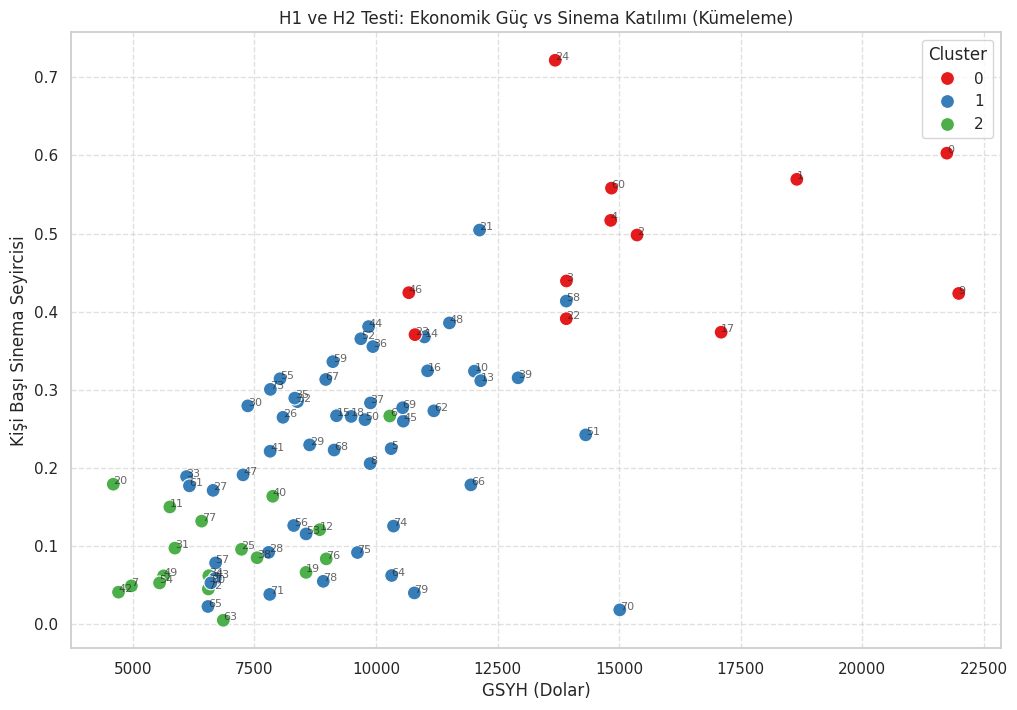

In [4]:
# --- ADIM 1: GEREKLİ KÜTÜPHANELERİ İÇE AKTAR (Week 8-11) ---
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# --- ADIM 2: ÖZELLİK SEÇİMİ VE NORMALİZASYON (Week 9 - Slide 47) ---
# Modelin kafasının karışmaması için sayısal verileri ölçeklendiriyoruz
features = ['GSYH_Dolar', 'Issizlik_Orani', 'KB_Sinema_Seyirci', 'KB_Tiyatro_Seyirci']
X = df_master[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- ADIM 3: K-MEANS KÜMELEME (Week 10 - Unsupervised Learning) ---
# Türkiye'deki illeri 3 ana gruba ayıralım
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_master['Cluster'] = kmeans.fit_predict(X_scaled)

# --- ADIM 4: GÖRSELLEŞTİRME ---
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_master, x='GSYH_Dolar', y='KB_Sinema_Seyirci', 
                hue='Cluster', palette='Set1', s=100)

# Şehir isimlerini noktaların yanına ekleyelim
for i, txt in enumerate(df_master.index):
    plt.annotate(txt, (df_master.GSYH_Dolar[i], df_master.KB_Sinema_Seyirci[i]), 
                 fontsize=8, alpha=0.7)

plt.title('H1 ve H2 Testi: Ekonomik Güç vs Sinema Katılımı (Kümeleme)')
plt.xlabel('GSYH (Dolar)')
plt.ylabel('Kişi Başı Sinema Seyircisi')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

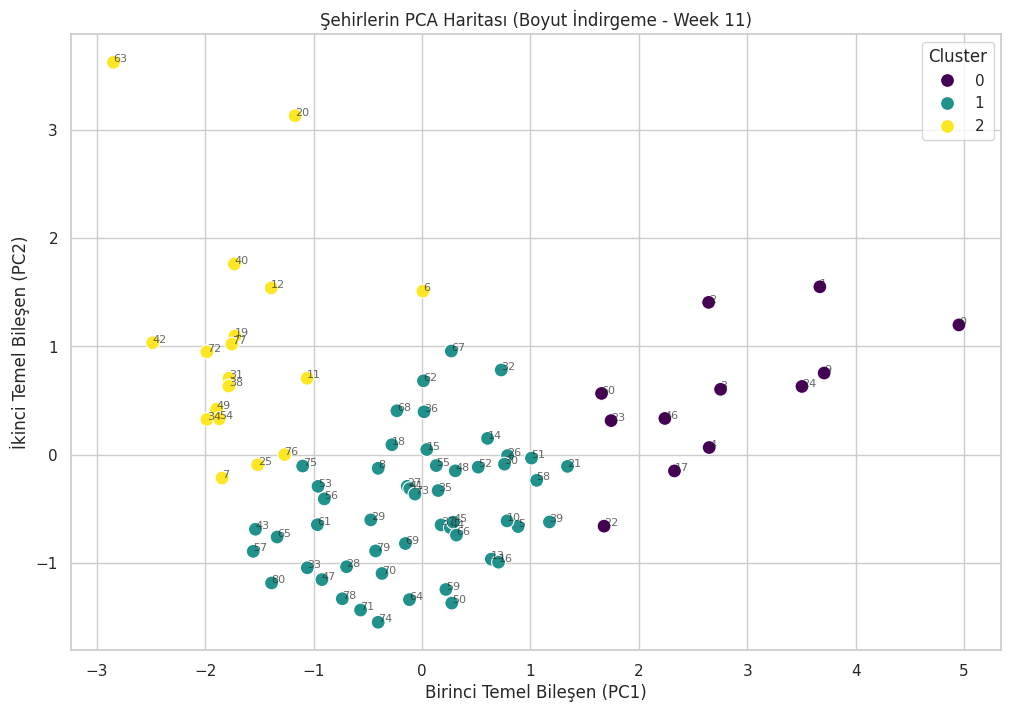

In [5]:
from sklearn.decomposition import PCA

# 1. PCA modelini oluştur (2 ana bileşene indirge)
pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled) # Daha önce ölçeklendirdiğimiz X_scaled'i kullanıyoruz

# 2. Sonuçları ana tabloya ekle
df_master['PC1'] = components[:, 0]
df_master['PC2'] = components[:, 1]

# 3. Görselleştirme (Week 11 - Slide 5: Data Visualization)
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_master, x='PC1', y='PC2', hue='Cluster', palette='viridis', s=100)

for i, txt in enumerate(df_master.index):
    plt.annotate(txt, (df_master.PC1[i], df_master.PC2[i]), fontsize=8, alpha=0.7)

plt.title('Şehirlerin PCA Haritası (Boyut İndirgeme - Week 11)')
plt.xlabel('Birinci Temel Bileşen (PC1)')
plt.ylabel('İkinci Temel Bileşen (PC2)')
plt.show()

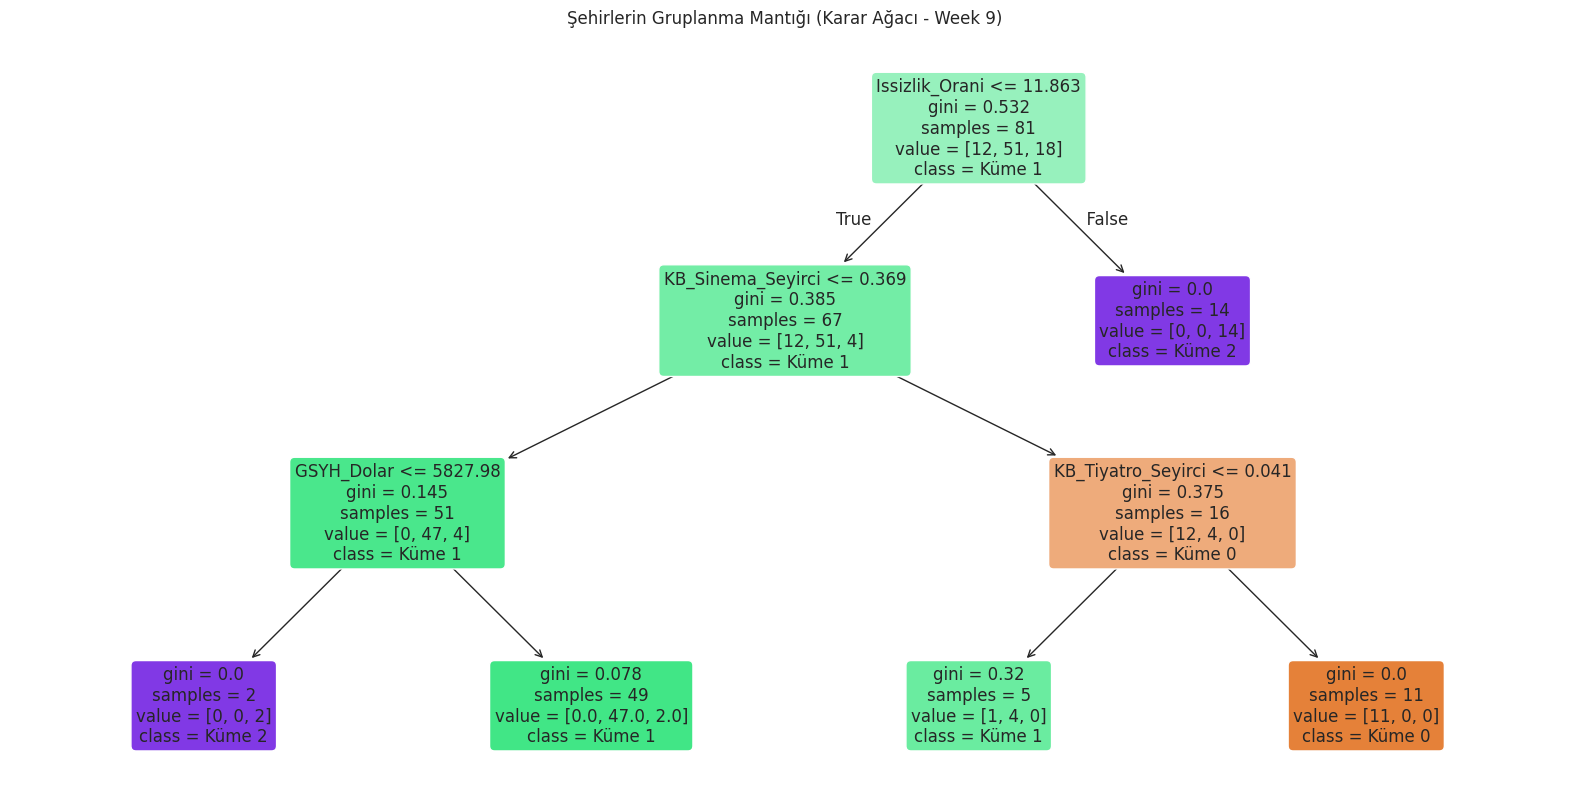

In [6]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Hedef değişkenimiz az önce oluşturduğumuz kümeler (Cluster) olsun
y = df_master['Cluster']

# Modeli eğit
clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(X, y)

# Ağacı görselleştir (Week 9 - Slide 3'teki gibi)
plt.figure(figsize=(20, 10))
plot_tree(clf, feature_names=features, class_names=['Küme 0', 'Küme 1', 'Küme 2'], 
          filled=True, rounded=True, fontsize=12)
plt.title('Şehirlerin Gruplanma Mantığı (Karar Ağacı - Week 9)')
plt.show()

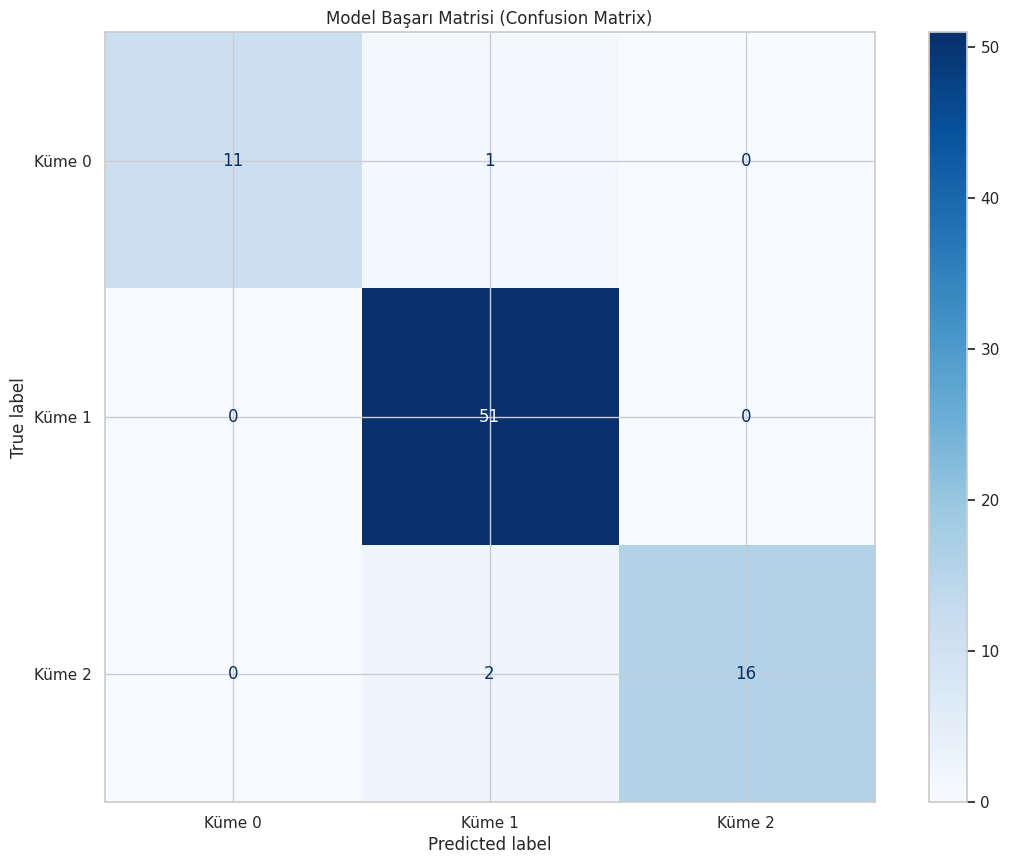

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Modelin tahminlerini al
y_pred = clf.predict(X)

# Hata matrisini oluştur
cm = confusion_matrix(df_master['Cluster'], y_pred)

# Görselleştir (Week 8 - Slide: Performance Metrics)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Küme 0', 'Küme 1', 'Küme 2'])
disp.plot(cmap='Blues')
plt.title('Model Başarı Matrisi (Confusion Matrix)')
plt.show()

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Bağımsız değişkenler (X) ve Hedef (y)
X_reg = df_master[['GSYH_Dolar', 'Issizlik_Orani']]
y_reg = df_master['KB_Sinema_Seyirci']

model_lin = LinearRegression()
model_lin.fit(X_reg, y_reg)

print(f"R-Kare Skoru: {model_lin.score(X_reg, y_reg):.3f}")
print(f"GSYH Katsayısı: {model_lin.coef_[0]:.6f}")


R-Kare Skoru: 0.500
GSYH Katsayısı: 0.000031


In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# 1. Değişkenleri Belirle
# Bağımsız Değişkenler (X): GSYH ve İşsizlik
X_reg = df_master[['GSYH_Dolar', 'Issizlik_Orani']]
# Hedef Değişken (y): Kişi Başı Sinema Seyircisi
y_reg = df_master['KB_Sinema_Seyirci']

# 2. Modeli Eğit (Week 9 - Slide 12)
reg_model = LinearRegression()
reg_model.fit(X_reg, y_reg)

# 3. Tahminleri Al
y_pred = reg_model.predict(X_reg)

# 4. Sonuçları Yazdır
print(f"--- Regresyon Sonuçları ---")
print(f"Model Denklemi: Y = {reg_model.intercept_:.4f} + ({reg_model.coef_[0]:.6f} * GSYH) + ({reg_model.coef_[1]:.4f} * İşsizlik)")
print(f"R-Kare (R2) Skoru: {r2_score(y_reg, y_pred):.3f}")
print(f"Hata Payı (MSE): {mean_squared_error(y_reg, y_pred):.5f}")

--- Regresyon Sonuçları ---
Model Denklemi: Y = -0.0558 + (0.000031 * GSYH) + (-0.0017 * İşsizlik)
R-Kare (R2) Skoru: 0.500
Hata Payı (MSE): 0.01234


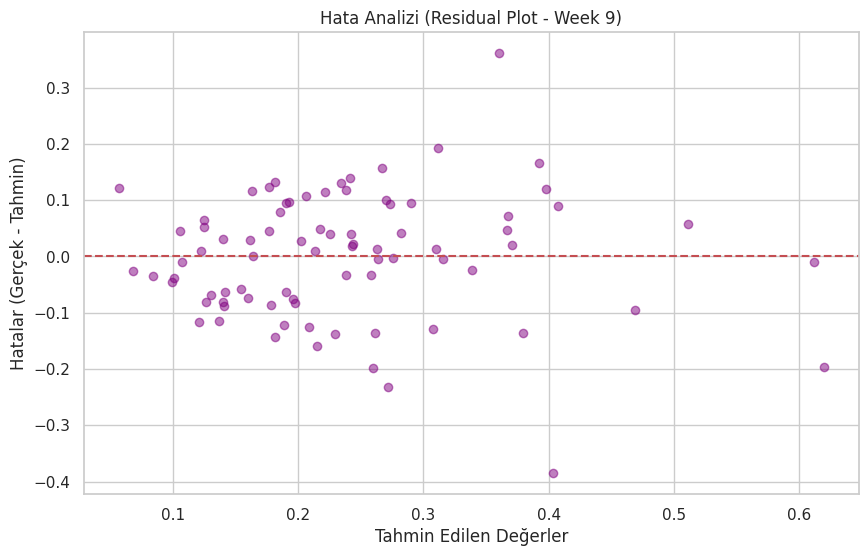

In [10]:
# Hataları (Residuals) Hesapla
residuals = y_reg - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='purple', alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Hata Analizi (Residual Plot - Week 9)')
plt.xlabel('Tahmin Edilen Değerler')
plt.ylabel('Hatalar (Gerçek - Tahmin)')
plt.show()

🚀 KAPSAMLI VERİMLİLİK VE KORELASYON ANALİZİ BAŞLIYOR...
📖 Okunuyor: issizlik.xls (Başlangıç: 8. satır)
📖 Okunuyor: sinema.xls (Başlangıç: 6. satır)
📖 Okunuyor: tiyatro.xls (Başlangıç: 7. satır)


/tmp/ipython-input-1072745147.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_issizlik['Il'] = df_issizlik['Il'].apply(sehir_ismi_duzelt)
/tmp/ipython-input-1072745147.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sinema['Il'] = df_sinema['Il'].apply(sehir_ismi_duzelt)
/tmp/ipython-input-1072745147.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

📖 Okunuyor: hasila.xls (Başlangıç: 6. satır)
🔄 Veriler Birleştiriliyor...
✅ Analiz Hazır! 78 il işleniyor.


/tmp/ipython-input-1072745147.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gsyh['Il'] = df_gsyh['Il'].apply(sehir_ismi_duzelt)


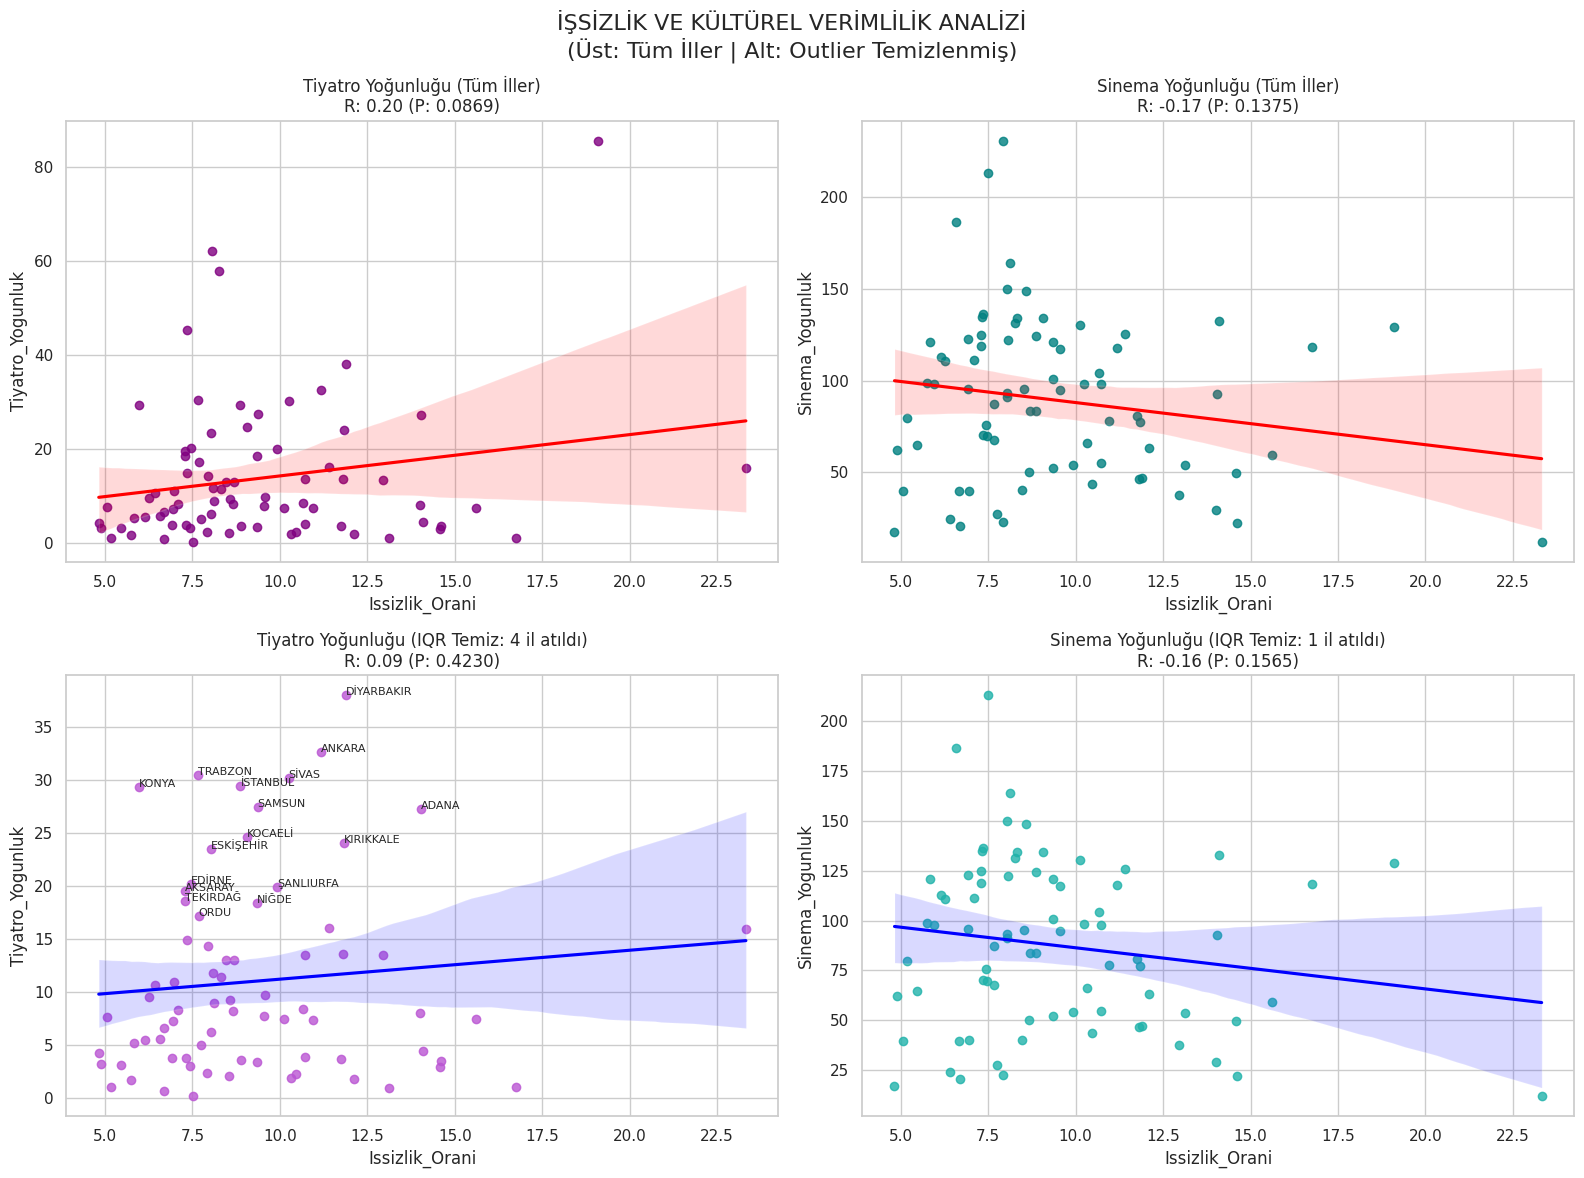


📊 DETAYLI SONUÇ TABLOSU
1️⃣ TİYATRO ANALİZİ:
   - TÜM İLLER: R=0.195 | P=0.08694 (ANLAMSIZ)
   - IQR TEMİZ: R=0.095  | P=0.42305  (ANLAMSIZ)
   * Atılan İller: ['BURSA', 'ÇORUM', 'ERZURUM', 'VAN']... (Toplam 4)
--------------------------------------------------------------------------------
2️⃣ SİNEMA ANALİZİ:
   - TÜM İLLER: R=-0.170 | P=0.13747 (ANLAMSIZ)
   - IQR TEMİZ: R=-0.163  | P=0.15646  (ANLAMSIZ)
   * Atılan İller: ['ELAZIĞ']... (Toplam 1)

🔥 KORELASYON ANALİZİ (TÜM DEĞİŞKENLER)


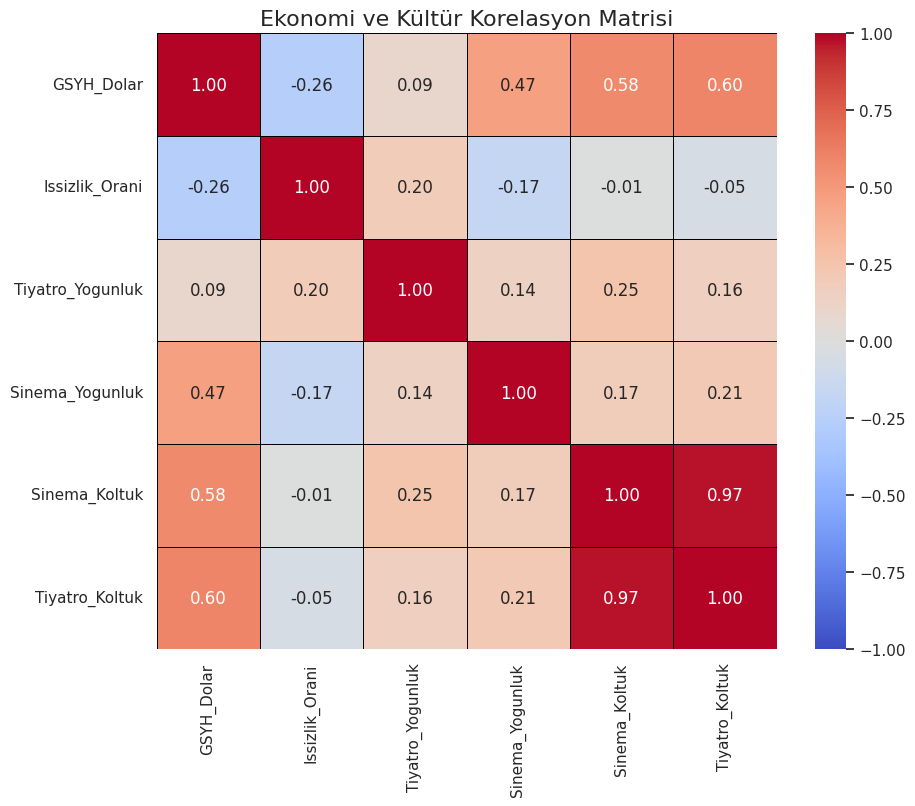

✅ Korelasyon Tablosu (Heatmap) Başarıyla Eklendi.

📈 EK ANALİZLER: ALTYAPI VE ZENGİNLİK İLİŞKİLERİ


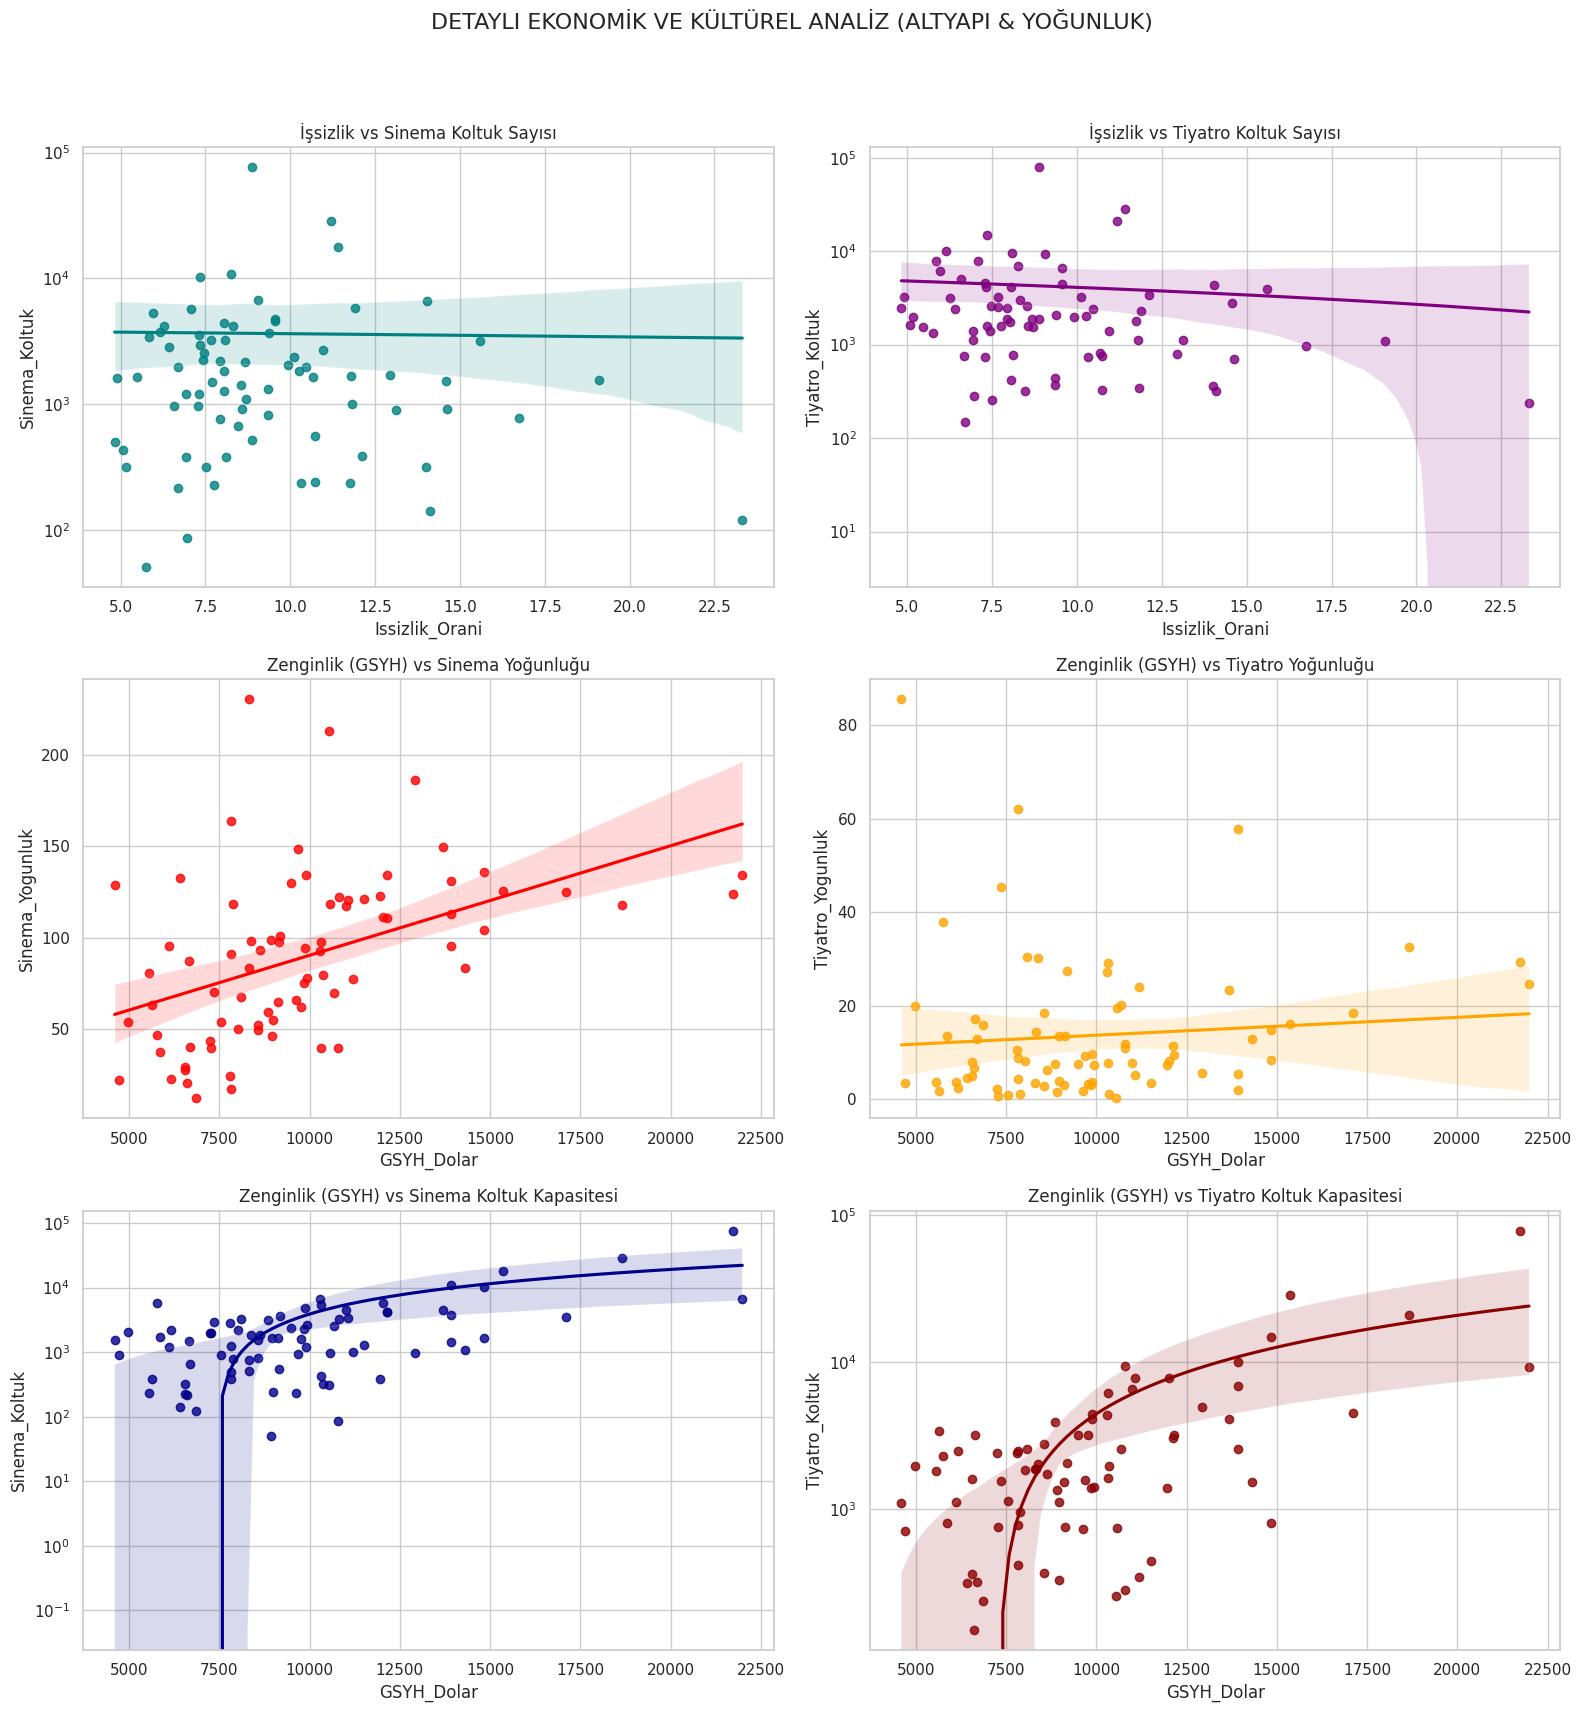

✅ Ekstra analiz grafikleri başarıyla çizildi.


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import os
from io import StringIO

# --- AYARLAR ---
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (16, 12)

# --- 1. FONKSİYONLAR ---
def sehir_ismi_duzelt(isim):
    if isinstance(isim, str):
        if "TR" in isim:
            if "," in isim: isim = isim.split(',')[1]
            elif " " in isim: isim = isim.split(' ', 1)[1]
        isim = isim.replace('i', 'İ').upper()
        isim = isim.replace('ı', 'I')
        return isim.strip()
    return ""

def dosya_oku_koordinatli(anahtar_kelime, satir_baslangic):
    dosyalar = os.listdir('.')
    dosya_yolu = next((f for f in dosyalar if anahtar_kelime.lower() in f.lower()), None)

    if not dosya_yolu:
        print(f"⚠️ UYARI: '{anahtar_kelime}' kelimesini içeren dosya bulunamadı!")
        return None

    print(f"📖 Okunuyor: {dosya_yolu} (Başlangıç: {satir_baslangic}. satır)")
    skip = satir_baslangic - 1

    try:
        # Önce CSV olarak dene
        try:
            return pd.read_csv(dosya_yolu, skiprows=skip, header=None, sep=None, engine='python')
        except:
            # Olmazsa Excel olarak dene
            return pd.read_excel(dosya_yolu, skiprows=skip, header=None)
    except Exception as e:
        print(f"❌ '{dosya_yolu}' dosyası okunurken hata oluştu: {e}")
        return None

# --- IQR FİLTRELEME FONKSİYONU ---
def iqr_filtrele(df, kolon):
    """Aykırı değerleri temizler ve temiz veriyi döndürür."""
    Q1 = df[kolon].quantile(0.25)
    Q3 = df[kolon].quantile(0.75)
    IQR = Q3 - Q1
    alt = Q1 - 1.5 * IQR
    ust = Q3 + 1.5 * IQR
    df_clean = df[(df[kolon] >= alt) & (df[kolon] <= ust)]
    atilan_sayisi = len(df) - len(df_clean)
    atilanlar = df[~df.index.isin(df_clean.index)]['Il'].tolist()
    return df_clean, atilan_sayisi, atilanlar

print("🚀 KAPSAMLI VERİMLİLİK VE KORELASYON ANALİZİ BAŞLIYOR...")

try:
    # ---------------------------------------------------------
    # ADIM 1: VERİ OKUMA (GÜVENLİ YÖNTEM)
    # ---------------------------------------------------------

    # 1. İşsizlik
    temp_issizlik = dosya_oku_koordinatli("issizlik", 8)
    if temp_issizlik is None: raise ValueError("İşsizlik dosyası okunamadı! Dosyaları yüklediğinden emin ol.")
    df_issizlik = temp_issizlik.iloc[:, [1, 7]]
    df_issizlik.columns = ['Il', 'Issizlik_Orani']
    df_issizlik['Il'] = df_issizlik['Il'].apply(sehir_ismi_duzelt)

    # 2. Sinema
    temp_sinema = dosya_oku_koordinatli("sinema", 6)
    if temp_sinema is None: raise ValueError("Sinema dosyası okunamadı!")
    df_sinema = temp_sinema.iloc[:, [0, 2, 8]]
    df_sinema.columns = ['Il', 'Sinema_Koltuk', 'Sinema_Seyirci']
    df_sinema['Il'] = df_sinema['Il'].apply(sehir_ismi_duzelt)

    # 3. Tiyatro
    temp_tiyatro = dosya_oku_koordinatli("tiyatro", 7)
    if temp_tiyatro is None: raise ValueError("Tiyatro dosyası okunamadı!")
    df_tiyatro = temp_tiyatro.iloc[:, [0, 2, 12]]
    df_tiyatro.columns = ['Il', 'Tiyatro_Koltuk', 'Tiyatro_Seyirci']
    df_tiyatro['Il'] = df_tiyatro['Il'].apply(sehir_ismi_duzelt)

    # 4. GSYH (Gelir)
    temp_gsyh = dosya_oku_koordinatli("hasila", 6)
    if temp_gsyh is None: raise ValueError("GSYH (Hasıla) dosyası okunamadı!")
    df_gsyh = temp_gsyh.iloc[:, [1, 42]]
    df_gsyh.columns = ['Il', 'GSYH_Dolar']
    df_gsyh['Il'] = df_gsyh['Il'].apply(sehir_ismi_duzelt)

    # ---------------------------------------------------------
    # ADIM 2: BİRLEŞTİRME VE HESAPLAMA
    # ---------------------------------------------------------
    print("🔄 Veriler Birleştiriliyor...")
    df_master = df_sinema.merge(df_tiyatro, on='Il', how='inner')
    df_master = df_master.merge(df_issizlik, on='Il', how='inner')
    df_master = df_master.merge(df_gsyh, on='Il', how='inner')

    # Temizlik
    cols = ['Issizlik_Orani', 'Sinema_Koltuk', 'Sinema_Seyirci', 'Tiyatro_Koltuk', 'Tiyatro_Seyirci', 'GSYH_Dolar']
    for col in cols: df_master[col] = pd.to_numeric(df_master[col], errors='coerce').fillna(0)

    df_master = df_master[~df_master['Il'].str.contains("TURKIYE|TOPLAM", na=False)]
    df_master = df_master[df_master['Sinema_Koltuk'] > 0] # 0'a bölme hatası önlemi

    # Verimlilik (Yoğunluk) Hesapları
    df_master['Tiyatro_Yogunluk'] = df_master['Tiyatro_Seyirci'] / df_master['Tiyatro_Koltuk']
    df_master['Sinema_Yogunluk'] = df_master['Sinema_Seyirci'] / df_master['Sinema_Koltuk']

    # Sonsuz değerleri temizle
    df_master = df_master.replace([np.inf, -np.inf], 0)

    print(f"✅ Analiz Hazır! {len(df_master)} il işleniyor.")

    # ---------------------------------------------------------
    # ADIM 3: VERİLERİ HAZIRLAMA (IQR vs STANDART)
    # ---------------------------------------------------------

    # IQR Temizlenmiş Veriler
    df_clean_tiyatro, atilan_t_sayi, atilan_t_isim = iqr_filtrele(df_master, 'Tiyatro_Yogunluk')
    df_clean_sinema, atilan_s_sayi, atilan_s_isim = iqr_filtrele(df_master, 'Sinema_Yogunluk')

    # İstatistikler
    r_t_orig, p_t_orig = pearsonr(df_master['Issizlik_Orani'], df_master['Tiyatro_Yogunluk'])
    r_s_orig, p_s_orig = pearsonr(df_master['Issizlik_Orani'], df_master['Sinema_Yogunluk'])

    r_t_iqr, p_t_iqr = pearsonr(df_clean_tiyatro['Issizlik_Orani'], df_clean_tiyatro['Tiyatro_Yogunluk'])
    r_s_iqr, p_s_iqr = pearsonr(df_clean_sinema['Issizlik_Orani'], df_clean_sinema['Sinema_Yogunluk'])

    # ---------------------------------------------------------
    # ADIM 4: GÖRSELLEŞTİRME (SCATTER PLOTS)
    # ---------------------------------------------------------

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('İŞSİZLİK VE KÜLTÜREL VERİMLİLİK ANALİZİ\n(Üst: Tüm İller | Alt: Outlier Temizlenmiş)', fontsize=16)

    # 1. Tiyatro (Tüm İller)
    sns.regplot(data=df_master, x='Issizlik_Orani', y='Tiyatro_Yogunluk', ax=axes[0,0], color='purple', line_kws={'color':'red'})
    axes[0,0].set_title(f"Tiyatro Yoğunluğu (Tüm İller)\nR: {r_t_orig:.2f} (P: {p_t_orig:.4f})")

    # 2. Sinema (Tüm İller)
    sns.regplot(data=df_master, x='Issizlik_Orani', y='Sinema_Yogunluk', ax=axes[0,1], color='teal', line_kws={'color':'red'})
    axes[0,1].set_title(f"Sinema Yoğunluğu (Tüm İller)\nR: {r_s_orig:.2f} (P: {p_s_orig:.4f})")

    # 3. Tiyatro (IQR Temizlenmiş)
    sns.regplot(data=df_clean_tiyatro, x='Issizlik_Orani', y='Tiyatro_Yogunluk', ax=axes[1,0], color='mediumorchid', line_kws={'color':'blue'})
    axes[1,0].set_title(f"Tiyatro Yoğunluğu (IQR Temiz: {atilan_t_sayi} il atıldı)\nR: {r_t_iqr:.2f} (P: {p_t_iqr:.4f})")

    # 4. Sinema (IQR Temizlenmiş)
    sns.regplot(data=df_clean_sinema, x='Issizlik_Orani', y='Sinema_Yogunluk', ax=axes[1,1], color='lightseagreen', line_kws={'color':'blue'})
    axes[1,1].set_title(f"Sinema Yoğunluğu (IQR Temiz: {atilan_s_sayi} il atıldı)\nR: {r_s_iqr:.2f} (P: {p_s_iqr:.4f})")

    # Şehir isimlerini yazdır
    for i in range(len(df_clean_tiyatro)):
        row = df_clean_tiyatro.iloc[i]
        if row['Tiyatro_Yogunluk'] > df_clean_tiyatro['Tiyatro_Yogunluk'].mean() * 1.5:
            axes[1,0].text(row['Issizlik_Orani'], row['Tiyatro_Yogunluk'], row['Il'], fontsize=8)

    plt.tight_layout()
    plt.show()

    # ---------------------------------------------------------
    # ADIM 5: SONUÇ RAPORU (TEXT)
    # ---------------------------------------------------------
    print("\n" + "="*80)
    print("📊 DETAYLI SONUÇ TABLOSU")
    print("="*80)

    print(f"1️⃣ TİYATRO ANALİZİ:")
    print(f"   - TÜM İLLER: R={r_t_orig:.3f} | P={p_t_orig:.5f} ({'ANLAMLI' if p_t_orig<0.05 else 'ANLAMSIZ'})")
    print(f"   - IQR TEMİZ: R={r_t_iqr:.3f}  | P={p_t_iqr:.5f}  ({'ANLAMLI' if p_t_iqr<0.05 else 'ANLAMSIZ'})")
    print(f"   * Atılan İller: {atilan_t_isim[:5]}... (Toplam {atilan_t_sayi})")

    print("-" * 80)

    print(f"2️⃣ SİNEMA ANALİZİ:")
    print(f"   - TÜM İLLER: R={r_s_orig:.3f} | P={p_s_orig:.5f} ({'ANLAMLI' if p_s_orig<0.05 else 'ANLAMSIZ'})")
    print(f"   - IQR TEMİZ: R={r_s_iqr:.3f}  | P={p_s_iqr:.5f}  ({'ANLAMLI' if p_s_iqr<0.05 else 'ANLAMSIZ'})")
    print(f"   * Atılan İller: {atilan_s_isim[:5]}... (Toplam {atilan_s_sayi})")
    print("="*80)

    # ---------------------------------------------------------
    # ADIM 6: EKSTRA - DETAYLI KORELASYON ANALİZİ (HEATMAP)
    # ---------------------------------------------------------

    print("\n" + "="*80)
    print("🔥 KORELASYON ANALİZİ (TÜM DEĞİŞKENLER)")
    print("="*80)

    # Analiz edilecek sütunları seç (Verimlilik Metrikleri + Ekonomi)
    analiz_sutunlari = [
        'GSYH_Dolar',
        'Issizlik_Orani',
        'Tiyatro_Yogunluk',
        'Sinema_Yogunluk',
        'Sinema_Koltuk',
        'Tiyatro_Koltuk'
    ]

    # Korelasyon matrisini hesapla
    corr_matrix = df_master[analiz_sutunlari].corr()

    # Isı Haritasını Çiz
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix,
                annot=True,
                fmt=".2f",
                cmap='coolwarm',
                vmin=-1, vmax=1,
                linewidths=0.5,
                linecolor='black')

    plt.title('Ekonomi ve Kültür Korelasyon Matrisi', fontsize=16)
    plt.show()

    print("✅ Korelasyon Tablosu (Heatmap) Başarıyla Eklendi.")
    # ---------------------------------------------------------
    # ADIM 7: EKSTRA - GENİŞLETİLMİŞ ANALİZ GRAFİKLERİ (YENİ İSTEK)
    # ---------------------------------------------------------

    print("\n" + "="*80)
    print("📈 EK ANALİZLER: ALTYAPI VE ZENGİNLİK İLİŞKİLERİ")
    print("="*80)

    # 3x2'lik Büyük Bir Grafik Paneli Oluştur
    fig_extra, axes_ex = plt.subplots(3, 2, figsize=(16, 18))
    fig_extra.suptitle('DETAYLI EKONOMİK VE KÜLTÜREL ANALİZ (ALTYAPI & YOĞUNLUK)', fontsize=16)

    # 1. İşsizlik vs Koltuk Sayısı (Altyapı)
    sns.regplot(data=df_master, x='Issizlik_Orani', y='Sinema_Koltuk', ax=axes_ex[0,0], color='teal')
    axes_ex[0,0].set_title('İşsizlik vs Sinema Koltuk Sayısı')
    axes_ex[0,0].set_yscale('log') # Logaritmik ölçek (İstanbul verisi grafiği bozmasın diye)

    sns.regplot(data=df_master, x='Issizlik_Orani', y='Tiyatro_Koltuk', ax=axes_ex[0,1], color='purple')
    axes_ex[0,1].set_title('İşsizlik vs Tiyatro Koltuk Sayısı')
    axes_ex[0,1].set_yscale('log')

    # 2. GSYH (Zenginlik) vs Yoğunluk (Verimlilik)
    sns.regplot(data=df_master, x='GSYH_Dolar', y='Sinema_Yogunluk', ax=axes_ex[1,0], color='red')
    axes_ex[1,0].set_title('Zenginlik (GSYH) vs Sinema Yoğunluğu')

    sns.regplot(data=df_master, x='GSYH_Dolar', y='Tiyatro_Yogunluk', ax=axes_ex[1,1], color='orange')
    axes_ex[1,1].set_title('Zenginlik (GSYH) vs Tiyatro Yoğunluğu')

    # 3. GSYH (Zenginlik) vs Koltuk Sayısı (Altyapı)
    sns.regplot(data=df_master, x='GSYH_Dolar', y='Sinema_Koltuk', ax=axes_ex[2,0], color='darkblue')
    axes_ex[2,0].set_title('Zenginlik (GSYH) vs Sinema Koltuk Kapasitesi')
    axes_ex[2,0].set_yscale('log')

    sns.regplot(data=df_master, x='GSYH_Dolar', y='Tiyatro_Koltuk', ax=axes_ex[2,1], color='darkred')
    axes_ex[2,1].set_title('Zenginlik (GSYH) vs Tiyatro Koltuk Kapasitesi')
    axes_ex[2,1].set_yscale('log')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Başlık için yer aç
    plt.show()

    print("✅ Ekstra analiz grafikleri başarıyla çizildi.")


except Exception as e:
    print(f"❌ HATA: {e}")

🎭 Tiyatro Verimlilik Analizi ve P-Value Testi Başlıyor...

🗑️ Çıkarılan Aykırı Şehirler (Anormal Doluluk): ['BAYBURT', 'ÇORUM', 'HAKKARİ', 'KİLİS', 'NİĞDE', 'TUNCELİ', 'YOZGAT']
✅ Analize Dahil Edilen Şehir Sayısı: 71


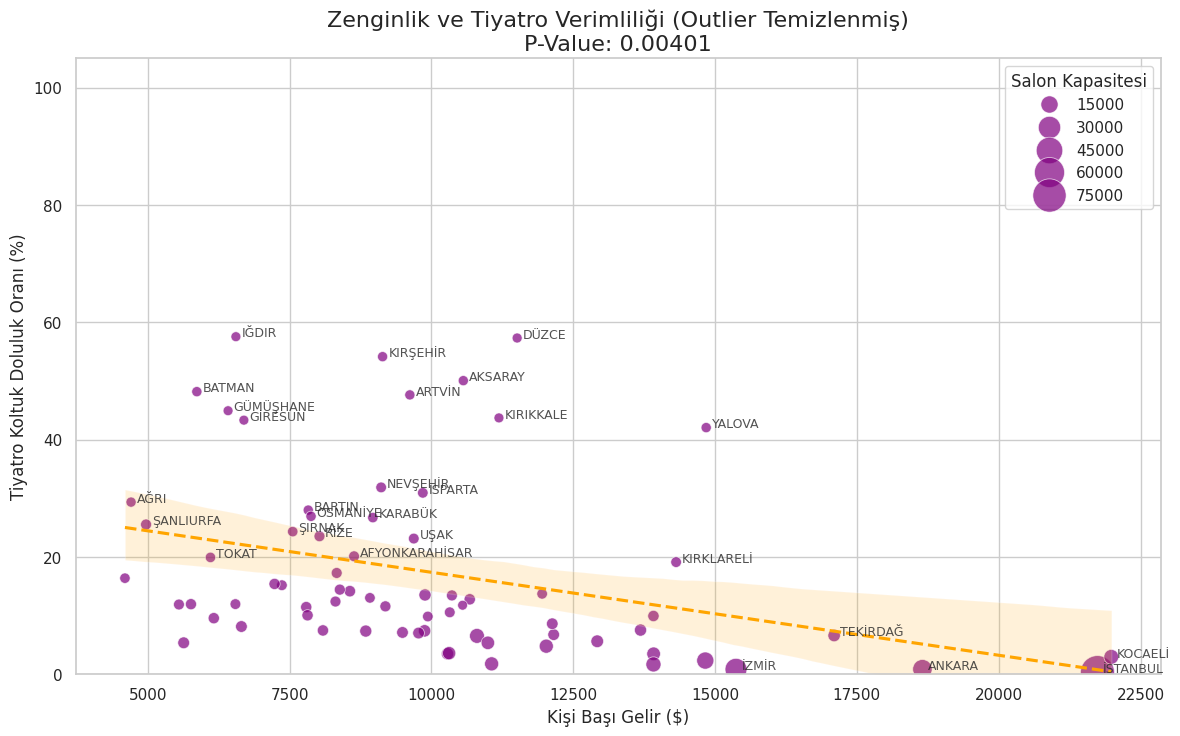


📢 İSTATİSTİKSEL SONUÇ RAPORU
🔹 Pearson Korelasyon Katsayısı (r): -0.3374
🔹 Spearman Korelasyon Katsayısı (rho): -0.4776
🔹 P-Değeri (p-value): 0.0040062989
--------------------------------------------------
✅ SONUÇ: İSTATİSTİKSEL OLARAK ANLAMLI BİR İLİŞKİ VAR! (Correlation Exists)
   (P-değeri 0.05'dan küçüktür.)
   👉 Yön: NEGATİF. Zengin şehirlerde salonlar daha boş kalıyor (Verimsizlik veya Arz Fazlası).
   👉 Güç: ORTA düzeyde bir ilişki.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

# --- AYARLAR ---
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

# Dosya İsimleri
dosya_tiyatro = "tiyatro.xls"
dosya_gsyh = "gsyh.xls"

# --- TÜRKÇE KARAKTER DÜZELTME ---
def sehir_ismi_duzelt(isim):
    if isinstance(isim, str):
        isim = isim.replace('i', 'İ').upper()
        isim = isim.replace('ı', 'I')
        return isim.strip()
    return ""

print("🎭 Tiyatro Verimlilik Analizi ve P-Value Testi Başlıyor...")

try:
    # 1. TİYATRO VERİSİ
    # Sütunlar: İl(0), Koltuk(2), Gösteri(8), Seyirci(12)
    try: df_tiyatro = pd.read_excel(dosya_tiyatro, skiprows=3)
    except: df_tiyatro = pd.read_csv("tiyatro.csv", skiprows=3, encoding='iso-8859-9')

    df_tiyatro = df_tiyatro.iloc[:, [0, 2, 8, 12]]
    df_tiyatro.columns = ['Il', 'Koltuk', 'Gosteri', 'Seyirci']
    df_tiyatro['Il'] = df_tiyatro['Il'].apply(sehir_ismi_duzelt)

    # Temizlik ve Sayısal Dönüşüm
    for col in ['Koltuk', 'Gosteri', 'Seyirci']:
        df_tiyatro[col] = pd.to_numeric(df_tiyatro[col], errors='coerce').fillna(0)

    # 0 kapasiteli ve Türkiye genel toplam satırını at
    df_tiyatro = df_tiyatro[df_tiyatro['Koltuk'] > 0]
    df_tiyatro = df_tiyatro[df_tiyatro['Gosteri'] > 0]
    df_tiyatro = df_tiyatro[df_tiyatro['Il'] != 'TÜRKİYE']
    df_tiyatro = df_tiyatro[df_tiyatro['Il'] != 'TURKIYE']

    # FORMÜL: Doluluk Oranı
    df_tiyatro['Kapasite'] = df_tiyatro['Koltuk'] * df_tiyatro['Gosteri']
    df_tiyatro['Doluluk_Orani'] = (df_tiyatro['Seyirci'] / df_tiyatro['Kapasite']) * 100

    # %100'ü geçenleri %100'e eşitle (Veri tutarsızlığını önlemek için)
    df_tiyatro.loc[df_tiyatro['Doluluk_Orani'] > 100, 'Doluluk_Orani'] = 100

    # 2. GSYH VERİSİ
    try: df_gsyh = pd.read_excel(dosya_gsyh, skiprows=3)
    except: df_gsyh = pd.read_csv("gsyh.csv", skiprows=3, encoding='iso-8859-9')

    df_gsyh = df_gsyh.iloc[:, [1, -1]]
    df_gsyh.columns = ['Il', 'GSYH_Dolar']
    df_gsyh['Il'] = df_gsyh['Il'].apply(sehir_ismi_duzelt)
    df_gsyh['GSYH_Dolar'] = pd.to_numeric(df_gsyh['GSYH_Dolar'], errors='coerce')

    # 3. BİRLEŞTİRME
    df_analiz = df_tiyatro.merge(df_gsyh, on='Il', how='inner')

    # GSYH verisi olmayanları temizle
    df_analiz = df_analiz.dropna(subset=['GSYH_Dolar', 'Doluluk_Orani'])

    # 4. OUTLIER TEMİZLİĞİ (IQR Yöntemi - Doluluk Oranına Göre)
    # Aşırı düşük veya aşırı yüksek (anormal) doluluk oranlarını çıkarıyoruz
    Q1 = df_analiz['Doluluk_Orani'].quantile(0.25)
    Q3 = df_analiz['Doluluk_Orani'].quantile(0.75)
    IQR = Q3 - Q1

    alt_sinir = Q1 - 1.5 * IQR
    ust_sinir = Q3 + 1.5 * IQR

    # Alt sınır negatif olamaz, 0 yapalım
    if alt_sinir < 0: alt_sinir = 0

    df_filtered = df_analiz[(df_analiz['Doluluk_Orani'] >= alt_sinir) & (df_analiz['Doluluk_Orani'] <= ust_sinir)]

    # Çıkarılanları göster
    cikarilanlar = df_analiz[~df_analiz.index.isin(df_filtered.index)]['Il'].tolist()
    print(f"\n🗑️ Çıkarılan Aykırı Şehirler (Anormal Doluluk): {cikarilanlar}")
    print(f"✅ Analize Dahil Edilen Şehir Sayısı: {len(df_filtered)}")

    # 5. İSTATİSTİKSEL TESTLER
    p_corr, p_val = pearsonr(df_filtered['GSYH_Dolar'], df_filtered['Doluluk_Orani'])
    s_corr, s_val = spearmanr(df_filtered['GSYH_Dolar'], df_filtered['Doluluk_Orani'])

    # 6. GRAFİK (SCATTER PLOT)
    plt.figure(figsize=(14, 8))

    sns.scatterplot(data=df_filtered,
                    x='GSYH_Dolar',
                    y='Doluluk_Orani',
                    size='Koltuk',
                    sizes=(50, 600),
                    color='purple',
                    alpha=0.7)

    # Regresyon Çizgisi
    sns.regplot(data=df_filtered, x='GSYH_Dolar', y='Doluluk_Orani', scatter=False, color='orange', line_kws={'linestyle':'--', 'label':f'Trend (Pearson: {p_corr:.2f})'})

    # Şehir İsimlerini Yazdır
    limit_doluluk = df_filtered['Doluluk_Orani'].mean()
    for i in range(df_filtered.shape[0]):
        row = df_filtered.iloc[i]
        # Sadece ortalamanın üstünde doluluğu olan veya çok zengin yerleri yaz
        if row['Doluluk_Orani'] > limit_doluluk or row['GSYH_Dolar'] > 15000:
            plt.text(row['GSYH_Dolar']+100, row['Doluluk_Orani'], row['Il'], fontsize=9, alpha=0.8)

    plt.title(f'Zenginlik ve Tiyatro Verimliliği (Outlier Temizlenmiş)\nP-Value: {p_val:.5f}', fontsize=16)
    plt.xlabel('Kişi Başı Gelir ($)', fontsize=12)
    plt.ylabel('Tiyatro Koltuk Doluluk Oranı (%)', fontsize=12)
    plt.ylim(0, 105)
    plt.legend(title='Salon Kapasitesi')

    plt.show()

    # --- 7. SONUÇ RAPORU ---
    print("\n" + "="*50)
    print("📢 İSTATİSTİKSEL SONUÇ RAPORU")
    print("="*50)
    print(f"🔹 Pearson Korelasyon Katsayısı (r): {p_corr:.4f}")
    print(f"🔹 Spearman Korelasyon Katsayısı (rho): {s_corr:.4f}")
    print(f"🔹 P-Değeri (p-value): {p_val:.10f}")
    print("-" * 50)

    alpha = 0.05
    if p_val < alpha:
        print("✅ SONUÇ: İSTATİSTİKSEL OLARAK ANLAMLI BİR İLİŞKİ VAR! (Correlation Exists)")
        print(f"   (P-değeri {alpha}'dan küçüktür.)")

        if p_corr > 0:
            print("   👉 Yön: POZİTİF. Zengin şehirlerde tiyatro salonları daha verimli kullanılıyor (Daha dolu).")
        else:
            print("   👉 Yön: NEGATİF. Zengin şehirlerde salonlar daha boş kalıyor (Verimsizlik veya Arz Fazlası).")

        if abs(p_corr) > 0.5: strength = "GÜÇLÜ"
        elif abs(p_corr) > 0.3: strength = "ORTA"
        else: strength = "ZAYIF"
        print(f"   👉 Güç: {strength} düzeyde bir ilişki.")

    else:
        print("❌ SONUÇ: İSTATİSTİKSEL OLARAK ANLAMLI BİR İLİŞKİ BULUNAMADI.")
        print("   (Zenginlik ile Tiyatro Doluluk Oranı arasında bilimsel bir bağlantı kurulamadı.)")
        print("   Yorum: Demek ki salonun dolu olması paraya değil, o şehrin sanat kültürüne veya oyun kalitesine bağlı.")

    print("="*50)

except Exception as e:
    print(f"❌ HATA: {e}")

🧪 P-Value Testi ve İstatistiksel Analiz Başlıyor...
✅ Analize Dahil Edilen Şehir Sayısı: 76


/tmp/ipython-input-2469966715.py:101: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


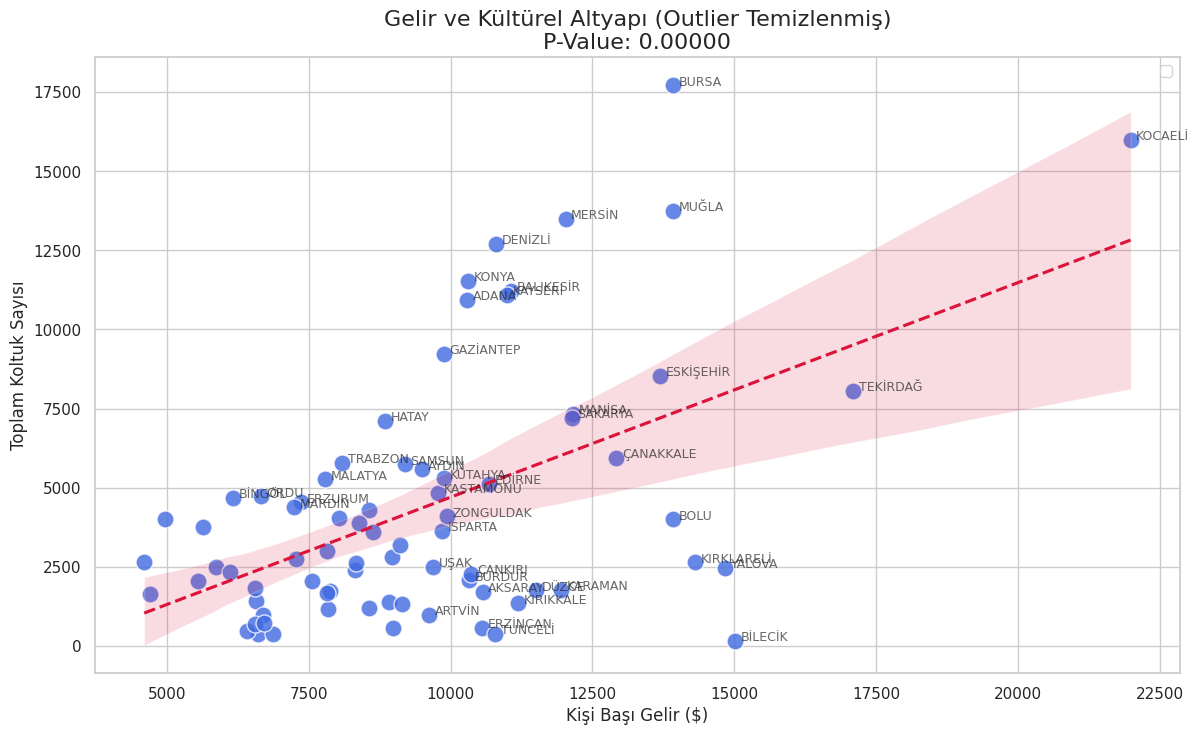


📢 İSTATİSTİKSEL SONUÇ RAPORU
🔹 Pearson Korelasyon Katsayısı (r): 0.5225
🔹 P-Değeri (p-value): 0.0000012886
--------------------------------------------------
✅ SONUÇ: İSTATİSTİKSEL OLARAK ANLAMLI BİR İLİŞKİ VAR! (Correlation Exists)
   (P-değeri 0.05'dan küçük olduğu için bu sonucun şans eseri olma ihtimali %0.00'dir.)
   👉 Yön: POZİTİF (Gelir arttıkça koltuk sayısı artıyor).
   👉 Güç: ORTA düzeyde bir ilişki.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

# --- AYARLAR ---
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

# Dosya İsimleri
dosya_sinema = "sinema.xls"
dosya_tiyatro = "tiyatro.xls"
dosya_gsyh = "gsyh.xls"

# --- TÜRKÇE KARAKTER DÜZELTME ---
def sehir_ismi_duzelt(isim):
    if isinstance(isim, str):
        isim = isim.replace('i', 'İ').upper()
        isim = isim.replace('ı', 'I')
        return isim.strip()
    return ""

print("🧪 P-Value Testi ve İstatistiksel Analiz Başlıyor...")

try:
    # 1. VERİLERİ OKU
    # A. Sinema
    try: df_sinema = pd.read_excel(dosya_sinema, skiprows=2)
    except: df_sinema = pd.read_csv("sinema.csv", skiprows=2, encoding='iso-8859-9')
    df_sinema = df_sinema.iloc[:, [0, 2]]
    df_sinema.columns = ['Il', 'Sinema_Koltuk']
    df_sinema['Il'] = df_sinema['Il'].apply(sehir_ismi_duzelt)

    # B. Tiyatro
    try: df_tiyatro = pd.read_excel(dosya_tiyatro, skiprows=3)
    except: df_tiyatro = pd.read_csv("tiyatro.csv", skiprows=3, encoding='iso-8859-9')
    df_tiyatro = df_tiyatro.iloc[:, [0, 2]]
    df_tiyatro.columns = ['Il', 'Tiyatro_Koltuk']
    df_tiyatro['Il'] = df_tiyatro['Il'].apply(sehir_ismi_duzelt)

    # C. GSYH
    try: df_gsyh = pd.read_excel(dosya_gsyh, skiprows=3)
    except: df_gsyh = pd.read_csv("gsyh.csv", skiprows=3, encoding='iso-8859-9')
    df_gsyh = df_gsyh.iloc[:, [1, -1]]
    df_gsyh.columns = ['Il', 'GSYH_Dolar']
    df_gsyh['Il'] = df_gsyh['Il'].apply(sehir_ismi_duzelt)

    # 2. BİRLEŞTİRME
    df_analiz = df_sinema.merge(df_tiyatro, on='Il', how='outer')
    df_analiz = df_analiz.merge(df_gsyh, on='Il', how='inner')

    # Temizlik
    cols = ['Sinema_Koltuk', 'Tiyatro_Koltuk', 'GSYH_Dolar']
    for col in cols:
        df_analiz[col] = pd.to_numeric(df_analiz[col], errors='coerce').fillna(0)

    df_analiz['Toplam_Koltuk'] = df_analiz['Sinema_Koltuk'] + df_analiz['Tiyatro_Koltuk']

    # "TÜRKİYE" ve eksik verileri çıkar
    df_analiz = df_analiz[df_analiz['Il'] != 'TÜRKİYE']
    df_analiz = df_analiz[df_analiz['Toplam_Koltuk'] > 0]
    df_analiz = df_analiz[df_analiz['GSYH_Dolar'] > 0]

    # 3. OUTLIER TESPİTİ (ORAN YÖNTEMİ + IQR)
    df_analiz['Oran'] = df_analiz['Toplam_Koltuk'] / df_analiz['GSYH_Dolar']

    Q1 = df_analiz['Oran'].quantile(0.25)
    Q3 = df_analiz['Oran'].quantile(0.75)
    IQR = Q3 - Q1
    alt_sinir = Q1 - 1.5 * IQR
    ust_sinir = Q3 + 1.5 * IQR

    df_filtered = df_analiz[(df_analiz['Oran'] >= alt_sinir) & (df_analiz['Oran'] <= ust_sinir)]

    print(f"✅ Analize Dahil Edilen Şehir Sayısı: {len(df_filtered)}")

    # 4. İSTATİSTİKSEL TESTLER (PEARSON & SPEARMAN + P-VALUE)
    # Pearson (Doğrusal)
    p_corr, p_val = pearsonr(df_filtered['GSYH_Dolar'], df_filtered['Toplam_Koltuk'])

    # Spearman (Sıralı)
    s_corr, s_val = spearmanr(df_filtered['GSYH_Dolar'], df_filtered['Toplam_Koltuk'])

    # 5. GRAFİK
    plt.figure(figsize=(14, 8))
    sns.scatterplot(data=df_filtered, x='GSYH_Dolar', y='Toplam_Koltuk', s=150, color='royalblue', alpha=0.8)
    sns.regplot(data=df_filtered, x='GSYH_Dolar', y='Toplam_Koltuk', scatter=False, color='crimson', line_kws={'linestyle':'--', 'label':f'Pearson R: {p_corr:.2f}'})

    # İsimleri Yazdır
    limit_koltuk = df_filtered['Toplam_Koltuk'].mean()
    limit_gelir = df_filtered['GSYH_Dolar'].mean()
    for i in range(df_filtered.shape[0]):
        row = df_filtered.iloc[i]
        if row['Toplam_Koltuk'] > limit_koltuk or row['GSYH_Dolar'] > limit_gelir:
            plt.text(row['GSYH_Dolar']+100, row['Toplam_Koltuk'], row['Il'], fontsize=9, alpha=0.7)

    plt.title(f'Gelir ve Kültürel Altyapı (Outlier Temizlenmiş)\nP-Value: {p_val:.5f}', fontsize=16)
    plt.xlabel('Kişi Başı Gelir ($)')
    plt.ylabel('Toplam Koltuk Sayısı')
    plt.legend()
    plt.show()

    # --- 6. SONUÇ RAPORU (BURASI YENİ) ---
    print("\n" + "="*50)
    print("📢 İSTATİSTİKSEL SONUÇ RAPORU")
    print("="*50)
    print(f"🔹 Pearson Korelasyon Katsayısı (r): {p_corr:.4f}")
    print(f"🔹 P-Değeri (p-value): {p_val:.10f}") # Çok küçük sayıları görebilmek için
    print("-" * 50)

    # KARAR MEKANİZMASI
    alpha = 0.05 # Bilimsel standart hata payı (%5)

    if p_val < alpha:
        print("✅ SONUÇ: İSTATİSTİKSEL OLARAK ANLAMLI BİR İLİŞKİ VAR! (Correlation Exists)")
        print(f"   (P-değeri {alpha}'dan küçük olduğu için bu sonucun şans eseri olma ihtimali %{p_val*100:.2f}'dir.)")

        if p_corr > 0:
            print("   👉 Yön: POZİTİF (Gelir arttıkça koltuk sayısı artıyor).")
        else:
            print("   👉 Yön: NEGATİF (Gelir arttıkça koltuk sayısı azalıyor).")

        # İlişki Gücü Yorumu
        if abs(p_corr) > 0.6: strength = "GÜÇLÜ"
        elif abs(p_corr) > 0.4: strength = "ORTA"
        else: strength = "ZAYIF"
        print(f"   👉 Güç: {strength} düzeyde bir ilişki.")

    else:
        print("❌ SONUÇ: İSTATİSTİKSEL OLARAK ANLAMLI BİR İLİŞKİ BULUNAMADI. (No Correlation)")
        print(f"   (P-değeri {alpha}'dan büyük. Görülen ilişki tesadüfi olabilir.)")

    print("="*50)

except Exception as e:
    print(f"❌ HATA: {e}")

🧪 Kişi Başına Düşen Koltuk Analizi Başlıyor...
✅ Analize Dahil Edilen Şehir Sayısı: 79
🗑️ Atılan Outlier Şehirler: ['BİNGÖL', 'ARDAHAN']


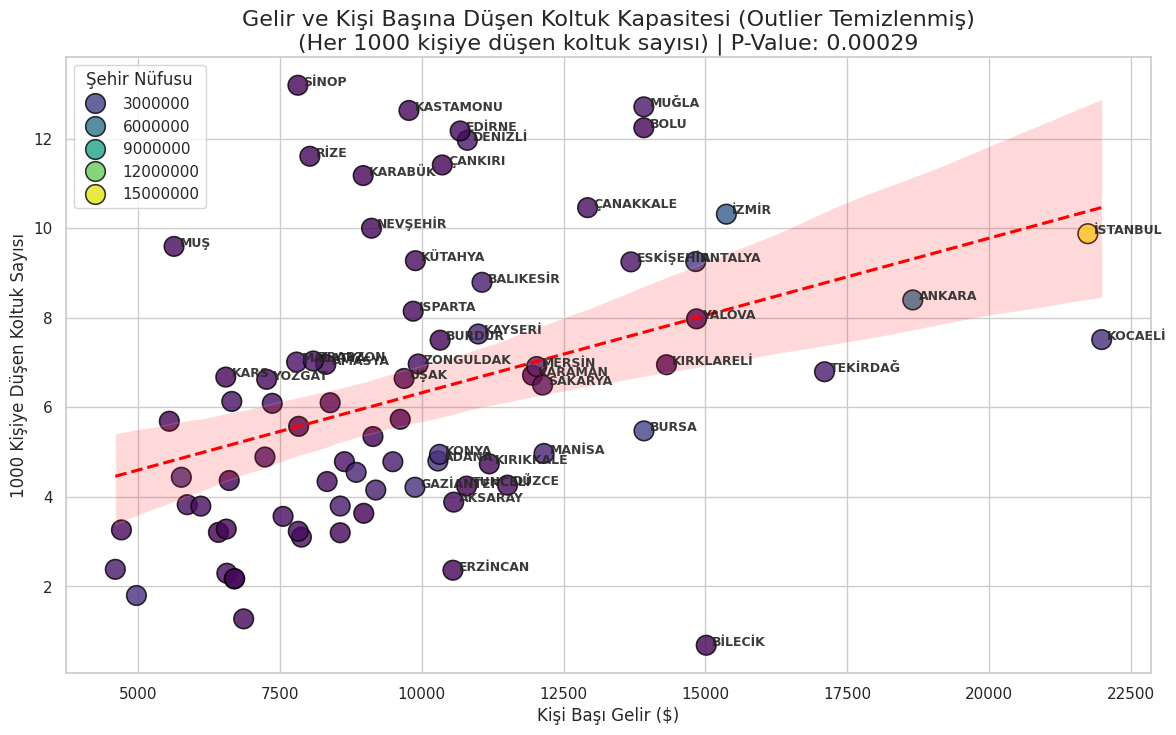


📢 İSTATİSTİKSEL SONUÇ RAPORU (Kişi Başı Koltuk)
🔹 Pearson Korelasyon Katsayısı (r): 0.3974
🔹 P-Değeri (p-value): 0.0002875969
--------------------------------------------------
✅ SONUÇ: İSTATİSTİKSEL OLARAK ANLAMLI BİR İLİŞKİ VAR!
   👉 Yön: POZİTİF. Zengin şehirlerde birey başına düşen kültürel alan daha fazla.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from io import StringIO

# --- AYARLAR ---
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

# Dosya İsimleri
dosya_sinema = "sinema.xls"
dosya_tiyatro = "tiyatro.xls"
dosya_gsyh = "gsyh.xls"

# --- TÜRKÇE KARAKTER DÜZELTME ---
def sehir_ismi_duzelt(isim):
    if isinstance(isim, str):
        isim = isim.replace('i', 'İ').upper()
        isim = isim.replace('ı', 'I')
        return isim.strip()
    return ""

print("🧪 Kişi Başına Düşen Koltuk Analizi Başlıyor...")

try:
    # 1. NÜFUS VERİSİ (Sabit)
    nufus_data = """
    Yil,Il,Nufus
    2023,İstanbul,15701602
    2023,Ankara,5864049
    2023,İzmir,4493242
    2023,Bursa,3238618
    2023,Antalya,2722103
    2023,Konya,2330024
    2023,Adana,2280484
    2023,Şanlıurfa,2237745
    2023,Gaziantep,2193363
    2023,Kocaeli,2130006
    2023,Mersin,1954279
    2023,Diyarbakır,1833684
    2023,Hatay,1562185
    2023,Manisa,1475353
    2023,Kayseri,1452458
    2023,Samsun,1382376
    2023,Balıkesir,1276096
    2023,Tekirdağ,1187162
    2023,Aydın,1165943
    2023,Kahramanmaraş,1134105
    2023,Van,1118087
    2023,Sakarya,1110735
    2023,Muğla,1081867
    2023,Denizli,1061371
    2023,Eskişehir,921630
    2023,Mardin,895911
    2023,Trabzon,822270
    2023,Ordu,770711
    2023,Malatya,750491
    2023,Afyonkarahisar,750193
    2023,Erzurum,745005
    2023,Batman,654528
    2023,Sivas,637007
    2023,Tokat,612674
    2023,Adıyaman,611037
    2023,Elazığ,603941
    2023,Zonguldak,586802
    2023,Kütahya,571078
    2023,Şırnak,570826
    2023,Çanakkale,568966
    2023,Osmaniye,561061
    2023,Çorum,521335
    2023,Ağrı,499801
    2023,Giresun,455922
    2023,Isparta,446409
    2023,Aksaray,439474
    2023,Edirne,421247
    2023,Yozgat,413161
    2023,Düzce,412344
    2023,Muş,392301
    2023,Kastamonu,381991
    2023,Kırklareli,379031
    2023,Uşak,375310
    2023,Niğde,372708
    2023,Bitlis,359808
    2023,Rize,346977
    2023,Amasya,342378
    2023,Siirt,336453
    2023,Bolu,326409
    2023,Nevşehir,317952
    2023,Yalova,307882
    2023,Bingöl,283276
    2023,Kırıkkale,283053
    2023,Hakkari,282191
    2023,Burdur,275826
    2023,Kars,272300
    2023,Karaman,262791
    2023,Karabük,250478
    2023,Kırşehir,244546
    2023,Erzincan,241239
    2023,Bilecik,228495
    2023,Sinop,226957
    2023,Iğdır,206857
    2023,Bartın,206715
    2023,Çankırı,199981
    2023,Artvin,169280
    2023,Kilis,156739
    2023,Gümüşhane,142617
    2023,Ardahan,91354
    2023,Tunceli,86612
    2023,Bayburt,83676
    """
    df_nufus = pd.read_csv(StringIO(nufus_data))
    df_nufus = df_nufus[['Il', 'Nufus']]
    df_nufus['Il'] = df_nufus['Il'].apply(sehir_ismi_duzelt)

    # 2. VERİLERİ OKU
    # A. Sinema
    try: df_sinema = pd.read_excel(dosya_sinema, skiprows=2)
    except: df_sinema = pd.read_csv("sinema.csv", skiprows=2, encoding='iso-8859-9')
    df_sinema = df_sinema.iloc[:, [0, 2]]
    df_sinema.columns = ['Il', 'Sinema_Koltuk']
    df_sinema['Il'] = df_sinema['Il'].apply(sehir_ismi_duzelt)

    # B. Tiyatro
    try: df_tiyatro = pd.read_excel(dosya_tiyatro, skiprows=3)
    except: df_tiyatro = pd.read_csv("tiyatro.csv", skiprows=3, encoding='iso-8859-9')
    df_tiyatro = df_tiyatro.iloc[:, [0, 2]]
    df_tiyatro.columns = ['Il', 'Tiyatro_Koltuk']
    df_tiyatro['Il'] = df_tiyatro['Il'].apply(sehir_ismi_duzelt)

    # C. GSYH
    try: df_gsyh = pd.read_excel(dosya_gsyh, skiprows=3)
    except: df_gsyh = pd.read_csv("gsyh.csv", skiprows=3, encoding='iso-8859-9')
    df_gsyh = df_gsyh.iloc[:, [1, -1]]
    df_gsyh.columns = ['Il', 'GSYH_Dolar']
    df_gsyh['Il'] = df_gsyh['Il'].apply(sehir_ismi_duzelt)

    # 3. BİRLEŞTİRME
    df_analiz = df_sinema.merge(df_tiyatro, on='Il', how='outer')
    df_analiz = df_analiz.merge(df_gsyh, on='Il', how='inner')
    df_analiz = df_analiz.merge(df_nufus, on='Il', how='inner') # Nüfus verisini de ekle

    # Temizlik
    cols = ['Sinema_Koltuk', 'Tiyatro_Koltuk', 'GSYH_Dolar', 'Nufus']
    for col in cols:
        df_analiz[col] = pd.to_numeric(df_analiz[col], errors='coerce').fillna(0)

    # KİŞİ BAŞI HESAPLAMA 🚨
    df_analiz['Toplam_Koltuk'] = df_analiz['Sinema_Koltuk'] + df_analiz['Tiyatro_Koltuk']
    df_analiz['Kisi_Basi_Koltuk'] = (df_analiz['Toplam_Koltuk'] / df_analiz['Nufus']) * 1000 # 1000 Kişiye düşen koltuk sayısı

    # "TÜRKİYE" ve eksik verileri çıkar
    df_analiz = df_analiz[df_analiz['Il'] != 'TÜRKİYE']
    df_analiz = df_analiz[df_analiz['Toplam_Koltuk'] > 0]
    df_analiz = df_analiz[df_analiz['GSYH_Dolar'] > 0]

    # 4. OUTLIER TESPİTİ (YENİ METRİĞE GÖRE)
    # Metrik: Kişi Başı Koltuk Sayısı (Bu zaten normalize olduğu için direkt kullanabiliriz)

    Q1 = df_analiz['Kisi_Basi_Koltuk'].quantile(0.25)
    Q3 = df_analiz['Kisi_Basi_Koltuk'].quantile(0.75)
    IQR = Q3 - Q1
    alt_sinir = Q1 - 1.5 * IQR
    ust_sinir = Q3 + 1.5 * IQR

    # Filtrele
    df_filtered = df_analiz[(df_analiz['Kisi_Basi_Koltuk'] >= alt_sinir) & (df_analiz['Kisi_Basi_Koltuk'] <= ust_sinir)]

    print(f"✅ Analize Dahil Edilen Şehir Sayısı: {len(df_filtered)}")
    print(f"🗑️ Atılan Outlier Şehirler: {list(set(df_analiz['Il']) - set(df_filtered['Il']))}")

    # 5. İSTATİSTİKSEL TESTLER
    # Pearson (Doğrusal)
    p_corr, p_val = pearsonr(df_filtered['GSYH_Dolar'], df_filtered['Kisi_Basi_Koltuk'])

    # Spearman (Sıralı)
    s_corr, s_val = spearmanr(df_filtered['GSYH_Dolar'], df_filtered['Kisi_Basi_Koltuk'])

    # 6. GRAFİK
    plt.figure(figsize=(14, 8))

    # Renk (Hue) olarak Nüfusu ekleyelim, bakalım küçük şehirler mi büyükler mi avantajlı
    sns.scatterplot(data=df_filtered,
                    x='GSYH_Dolar',
                    y='Kisi_Basi_Koltuk',
                    s=200,
                    hue='Nufus',
                    palette='viridis',
                    edgecolor='black',
                    alpha=0.8)

    sns.regplot(data=df_filtered, x='GSYH_Dolar', y='Kisi_Basi_Koltuk', scatter=False, color='red', line_kws={'linestyle':'--', 'label':f'Trend (Pearson: {p_corr:.2f})'})

    # İsimleri Yazdır
    limit_kisi_basi = df_filtered['Kisi_Basi_Koltuk'].mean()
    limit_gelir = df_filtered['GSYH_Dolar'].mean()
    for i in range(df_filtered.shape[0]):
        row = df_filtered.iloc[i]
        # Ortalamanın üstünde olanları yazdır
        if row['Kisi_Basi_Koltuk'] > limit_kisi_basi or row['GSYH_Dolar'] > limit_gelir:
            plt.text(row['GSYH_Dolar']+100, row['Kisi_Basi_Koltuk'], row['Il'], fontsize=9, alpha=0.9, fontweight='bold')

    plt.title(f'Gelir ve Kişi Başına Düşen Koltuk Kapasitesi (Outlier Temizlenmiş)\n(Her 1000 kişiye düşen koltuk sayısı) | P-Value: {p_val:.5f}', fontsize=16)
    plt.xlabel('Kişi Başı Gelir ($)')
    plt.ylabel('1000 Kişiye Düşen Koltuk Sayısı')
    plt.legend(title='Şehir Nüfusu')
    plt.show()

    # --- 7. SONUÇ RAPORU ---
    print("\n" + "="*50)
    print("📢 İSTATİSTİKSEL SONUÇ RAPORU (Kişi Başı Koltuk)")
    print("="*50)
    print(f"🔹 Pearson Korelasyon Katsayısı (r): {p_corr:.4f}")
    print(f"🔹 P-Değeri (p-value): {p_val:.10f}")
    print("-" * 50)

    alpha = 0.05
    if p_val < alpha:
        print("✅ SONUÇ: İSTATİSTİKSEL OLARAK ANLAMLI BİR İLİŞKİ VAR!")
        if p_corr > 0:
            print("   👉 Yön: POZİTİF. Zengin şehirlerde birey başına düşen kültürel alan daha fazla.")
        else:
            print("   👉 Yön: NEGATİF. Zengin şehirler kalabalık olduğu için kişi başına düşen koltuk azalıyor olabilir.")
    else:
        print("❌ SONUÇ: ANLAMLI BİR İLİŞKİ BULUNAMADI.")
        print("   Yorum: Demek ki bir şehrin zengin olması, vatandaşına daha fazla koltuk sunduğu anlamına gelmiyor.")
        print("   (Belki küçük ama fakir şehirlerde kişi başına düşen koltuk, nüfus az olduğu için yüksek çıkıyordur).")

    print("="*50)

except Exception as e:
    print(f"❌ HATA: {e}")